In [14]:
#!pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install statsmodel
#!pip install lightgbm
#!pip install -U scikit-learn
#!pip install statsmodels

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AutoReg
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from pylab import savefig
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose




In [16]:
df = pd.read_csv('./final_raw_data_2021.csv')


**Exploratory Data Analysis**

describing the data 

In [17]:
df.describe()

station_uuid         diesel             e5            e10  \
count  161913.000000  159485.000000  159485.000000  159485.000000   
mean        9.808891       1.415028       1.611215       1.551857   
std         5.219009       0.859898       0.986534       0.949872   
min         1.000000       1.109000       1.269000       1.219000   
25%         5.000000       1.319000       1.529000       1.469000   
50%        10.000000       1.389000       1.609000       1.549000   
75%        14.000000       1.489000       1.669000       1.609000   
max        19.000000     128.428000     144.904000     139.961000   

        dieselchange       e5change      e10change  
count  157879.000000  157879.000000  157879.000000  
mean        0.784778       0.822326       0.822370  
std         0.418809       0.390648       0.390611  
min         0.000000       0.000000       0.000000  
25%         1.000000       1.000000       1.000000  
50%         1.000000       1.000000       1.000000  
75%         1.000000       1.000000       1.000000  
max         3.000000       3.000000       3.000000

presence of null values

In [18]:
df.isnull().sum()

date               0
station_uuid       0
diesel          2428
e5              2428
e10             2428
dieselchange    4034
e5change        4034
e10change       4034
dtype: int64

sample data values 

In [19]:
df.head()

date  station_uuid  diesel     e5    e10  dieselchange  \
0  2021-01-01 01:03:15+01             7   1.259  1.399  1.349           1.0   
1  2021-01-01 05:53:14+01             7   1.289  1.429  1.379           1.0   
2  2021-01-01 06:53:14+01             7   1.319  1.489  1.439           1.0   
3  2021-01-01 09:59:08+01             7   1.189  1.359  1.309           1.0   
4  2021-01-01 10:25:15+01             7   1.229  1.399  1.349           1.0   

   e5change  e10change  
0       1.0        1.0  
1       1.0        1.0  
2       1.0        1.0  
3       1.0        1.0  
4       1.0        1.0

spliting date values till hour 

In [20]:
df ['date'] = df['date'].str.split(r":", expand=True)[0]


In [21]:
df

date  station_uuid  diesel     e5    e10  dieselchange  \
0       2021-01-01 01             7   1.259  1.399  1.349           1.0   
1       2021-01-01 05             7   1.289  1.429  1.379           1.0   
2       2021-01-01 06             7   1.319  1.489  1.439           1.0   
3       2021-01-01 09             7   1.189  1.359  1.309           1.0   
4       2021-01-01 10             7   1.229  1.399  1.349           1.0   
...               ...           ...     ...    ...    ...           ...   
161908  2021-12-31 17            10   1.559  1.729  1.669           1.0   
161909  2021-12-31 18            10   1.529  1.699  1.639           1.0   
161910  2021-12-31 19            10   1.569  1.739  1.679           1.0   
161911  2021-12-31 20            10   1.529  1.699  1.639           1.0   
161912  2021-12-31 22            10   1.559  1.729  1.669           1.0   

        e5change  e10change  
0            1.0        1.0  
1            1.0        1.0  
2            1.0        1.0  
3            1.0        1.0  
4            1.0        1.0  
...          ...        ...  
161908       1.0        1.0  
161909       1.0        1.0  
161910       1.0        1.0  
161911       1.0        1.0  
161912       1.0        1.0  

[161913 rows x 8 columns]

Converting date format to date time for easy analysis

In [22]:
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d %H', exact=True,utc=True)

In [23]:
df

date  station_uuid  diesel     e5    e10  \
0      2021-01-01 01:00:00+00:00             7   1.259  1.399  1.349   
1      2021-01-01 05:00:00+00:00             7   1.289  1.429  1.379   
2      2021-01-01 06:00:00+00:00             7   1.319  1.489  1.439   
3      2021-01-01 09:00:00+00:00             7   1.189  1.359  1.309   
4      2021-01-01 10:00:00+00:00             7   1.229  1.399  1.349   
...                          ...           ...     ...    ...    ...   
161908 2021-12-31 17:00:00+00:00            10   1.559  1.729  1.669   
161909 2021-12-31 18:00:00+00:00            10   1.529  1.699  1.639   
161910 2021-12-31 19:00:00+00:00            10   1.569  1.739  1.679   
161911 2021-12-31 20:00:00+00:00            10   1.529  1.699  1.639   
161912 2021-12-31 22:00:00+00:00            10   1.559  1.729  1.669   

        dieselchange  e5change  e10change  
0                1.0       1.0        1.0  
1                1.0       1.0        1.0  
2                1.0       1.0        1.0  
3                1.0       1.0        1.0  
4                1.0       1.0        1.0  
...              ...       ...        ...  
161908           1.0       1.0        1.0  
161909           1.0       1.0        1.0  
161910           1.0       1.0        1.0  
161911           1.0       1.0        1.0  
161912           1.0       1.0        1.0  

[161913 rows x 8 columns]

In [24]:
df.dtypes

date            datetime64[ns, UTC]
station_uuid                  int64
diesel                      float64
e5                          float64
e10                         float64
dieselchange                float64
e5change                    float64
e10change                   float64
dtype: object

Corelation matrix

In [25]:
cormat = df.corr()
round(cormat,2)
cor1 = sns.heatmap(cormat)
figure = cor1.get_figure() 
figure.savefig('cor1.svg', dpi=400)

C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\3221887264.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cormat = df.corr()


dropping columns


In [26]:
df =df.drop(['dieselchange','e5change','e10change'], axis=1)

In [27]:
df

date  station_uuid  diesel     e5    e10
0      2021-01-01 01:00:00+00:00             7   1.259  1.399  1.349
1      2021-01-01 05:00:00+00:00             7   1.289  1.429  1.379
2      2021-01-01 06:00:00+00:00             7   1.319  1.489  1.439
3      2021-01-01 09:00:00+00:00             7   1.189  1.359  1.309
4      2021-01-01 10:00:00+00:00             7   1.229  1.399  1.349
...                          ...           ...     ...    ...    ...
161908 2021-12-31 17:00:00+00:00            10   1.559  1.729  1.669
161909 2021-12-31 18:00:00+00:00            10   1.529  1.699  1.639
161910 2021-12-31 19:00:00+00:00            10   1.569  1.739  1.679
161911 2021-12-31 20:00:00+00:00            10   1.529  1.699  1.639
161912 2021-12-31 22:00:00+00:00            10   1.559  1.729  1.669

[161913 rows x 5 columns]

In [28]:
df = df.drop_duplicates()

In [29]:
df

date  station_uuid  diesel     e5    e10
0      2021-01-01 01:00:00+00:00             7   1.259  1.399  1.349
1      2021-01-01 05:00:00+00:00             7   1.289  1.429  1.379
2      2021-01-01 06:00:00+00:00             7   1.319  1.489  1.439
3      2021-01-01 09:00:00+00:00             7   1.189  1.359  1.309
4      2021-01-01 10:00:00+00:00             7   1.229  1.399  1.349
...                          ...           ...     ...    ...    ...
161908 2021-12-31 17:00:00+00:00            10   1.559  1.729  1.669
161909 2021-12-31 18:00:00+00:00            10   1.529  1.699  1.639
161910 2021-12-31 19:00:00+00:00            10   1.569  1.739  1.679
161911 2021-12-31 20:00:00+00:00            10   1.529  1.699  1.639
161912 2021-12-31 22:00:00+00:00            10   1.559  1.729  1.669

[161300 rows x 5 columns]

filling null values using linear interpolation method 

In [30]:
df[['diesel', 'e5', 'e10']]= df[['diesel', 'e5', 'e10']].interpolate(method='linear')

C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\1341309545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['diesel', 'e5', 'e10']]= df[['diesel', 'e5', 'e10']].interpolate(method='linear')


In [31]:
cormat = df.corr()
round(cormat,2)
sns.heatmap(cormat);

C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\3580107550.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cormat = df.corr()


Removing Outliers by defining interquartile range and removing outliers above and below 75 and 25 percentile respectively

In [32]:
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1

    print("IQR value for column %s is: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data

    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_list = [x for x in data[col] if (
        (x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_list)]
df_new = pd.DataFrame([]) 
for n in range(df['station_uuid'].nunique()):
  df_station = df[df.station_uuid==n+1] 
  for i in ['diesel','e5','e10']:
    if i == 'diesel':
      removeOutliers(df_station, i)
    else:
        removeOutliers(filtered_data, i)     #assigning filtered values on to a new data frame
  df_new =df_new.append(filtered_data)



print("Shape of data after outlier removal is: ", df_new.shape)

IQR value for column diesel is: 0.18999999999999995
IQR value for column e5 is: 0.13000000000000012
IQR value for column e10 is: 0.1200000000000001
IQR value for column diesel is: 0.18999999999999995
IQR value for column e5 is: 0.1200000000000001
IQR value for column e10 is: 0.1200000000000001
IQR value for column diesel is: 0.17999999999999994
IQR value for column e5 is: 0.1200000000000001
IQR value for column e10 is: 0.11999999999999988
IQR value for column diesel is: 0.18000000000000016
IQR value for column e5 is: 0.1200000000000001
IQR value for column e10 is: 0.1299999999999999
IQR value for column diesel is: 0.14000000000000012
IQR value for column e5 is: 0.13000000000000012
IQR value for column e10 is: 0.1299999999999999
IQR value for column diesel is: 0.18999999999999995
IQR value for column e5 is: 0.15000000000000013
IQR value for column e10 is: 0.1499999999999999
IQR value for column diesel is: 0.16000000000000014
IQR value for column e5 is: 0.1200000000000001
IQR value for c

C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2980815046.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new =df_new.append(filtered_data)
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2980815046.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new =df_new.append(filtered_data)
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2980815046.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new =df_new.append(filtered_data)
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2980815046.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new =df_new.append(filtered_data)
C:\Users\gowth\AppData\Local\Temp\ipyker

IQR value for column diesel is: 0.10000000000000009
IQR value for column e5 is: 0.10000000000000009
IQR value for column e10 is: 0.09999999999999987
IQR value for column diesel is: 0.13000000000000012
IQR value for column e5 is: 0.1200000000000001
IQR value for column e10 is: 0.11999999999999988
IQR value for column diesel is: 0.14000000000000012
IQR value for column e5 is: 0.1100000000000001
IQR value for column e10 is: 0.10999999999999988
IQR value for column diesel is: 0.16000000000000014
IQR value for column e5 is: 0.18000000000000016
IQR value for column e10 is: 0.17999999999999994
IQR value for column diesel is: 0.15000000000000013
IQR value for column e5 is: 0.17000000000000015
IQR value for column e10 is: 0.16999999999999993
IQR value for column diesel is: 0.15000000000000013
IQR value for column e5 is: 0.16999999999999993
IQR value for column e10 is: 0.16999999999999993
IQR value for column diesel is: 0.15000000000000013
IQR value for column e5 is: 0.17000000000000015
IQR valu

C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2980815046.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new =df_new.append(filtered_data)
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2980815046.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new =df_new.append(filtered_data)
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2980815046.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new =df_new.append(filtered_data)
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2980815046.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new =df_new.append(filtered_data)
C:\Users\gowth\AppData\Local\Temp\ipyker

IQR value for column diesel is: 0.17000000000000015
IQR value for column e5 is: 0.16000000000000014
IQR value for column e10 is: 0.15999999999999992
IQR value for column diesel is: 0.08000000000000007
IQR value for column e5 is: 0.07000000000000006
IQR value for column e10 is: 0.06000000000000005
Shape of data after outlier removal is:  (159797, 5)


C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2980815046.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new =df_new.append(filtered_data)
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2980815046.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new =df_new.append(filtered_data)
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2980815046.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new =df_new.append(filtered_data)


Corelation matrix after outlier removal 

In [33]:
df_new.describe()

station_uuid         diesel             e5            e10
count  159797.000000  159797.000000  159797.000000  159797.000000
mean        9.814921       1.407582       1.602978       1.543902
std         5.206892       0.109156       0.105874       0.104700
min         1.000000       1.139000       1.309000       1.259000
25%         5.000000       1.329000       1.529000       1.469000
50%        10.000000       1.389000       1.609000       1.549000
75%        14.000000       1.489000       1.669000       1.609000
max        19.000000       1.829000       1.969000       1.919000

C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\3736941763.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cormat = df_new.corr()


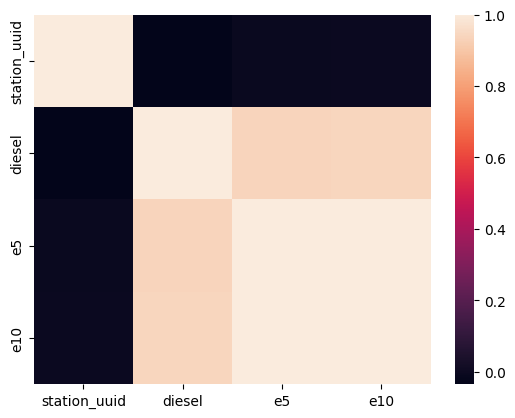

In [34]:
cormat = df_new.corr()
round(cormat,2)
cor= sns.heatmap(cormat);
figure = cor.get_figure() 
figure.savefig('cor.svg')

index for hourly date range 2021-01-01 till 2021-12-31

In [35]:
date = pd.date_range(start='2021-01-01', end='2022-01-01', freq='H',tz='UTC')

In [36]:
date = date[:-1]

In [37]:
date

DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-01 01:00:00+00:00',
               '2021-01-01 02:00:00+00:00', '2021-01-01 03:00:00+00:00',
               '2021-01-01 04:00:00+00:00', '2021-01-01 05:00:00+00:00',
               '2021-01-01 06:00:00+00:00', '2021-01-01 07:00:00+00:00',
               '2021-01-01 08:00:00+00:00', '2021-01-01 09:00:00+00:00',
               ...
               '2021-12-31 14:00:00+00:00', '2021-12-31 15:00:00+00:00',
               '2021-12-31 16:00:00+00:00', '2021-12-31 17:00:00+00:00',
               '2021-12-31 18:00:00+00:00', '2021-12-31 19:00:00+00:00',
               '2021-12-31 20:00:00+00:00', '2021-12-31 21:00:00+00:00',
               '2021-12-31 22:00:00+00:00', '2021-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8760, freq='H')

Upsampling data to hourly periods by upsampling using linear interpolation for each station 

In [38]:
aggdf2=pd.DataFrame([])
for n in range(df['station_uuid'].nunique()):
   temp = df_new[df_new.station_uuid==n+1].set_index('date')
   temp = temp.loc[~temp.index.duplicated(), :]
   temp = temp.reindex(date).interpolate(method = 'linear')
   temp['station_uuid'] =n+1
   temp = temp.interpolate(method = 'linear')
   temp = temp.fillna(method="bfill")
   aggdf2 =aggdf2.append(temp)


C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\1369780393.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aggdf2 =aggdf2.append(temp)
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\1369780393.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aggdf2 =aggdf2.append(temp)
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\1369780393.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aggdf2 =aggdf2.append(temp)
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\1369780393.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aggdf2 =aggdf2.append(temp)
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\1369780393.py:9: FutureWarning

In [39]:
aggdf2.isnull().sum()

station_uuid    0
diesel          0
e5              0
e10             0
dtype: int64

In [40]:
aggdf2.describe()

station_uuid         diesel             e5            e10
count  166440.000000  166440.000000  166440.000000  166440.000000
mean       10.000000       1.421717       1.618663       1.560109
std         5.477242       0.120945       0.116522       0.116111
min         1.000000       1.139000       1.309000       1.259000
25%         5.000000       1.329000       1.539000       1.479000
50%        10.000000       1.399000       1.617750       1.557661
75%        15.000000       1.519000       1.694000       1.634000
max        19.000000       1.829000       1.969000       1.919000

In [41]:
aggdf2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166440 entries, 2021-01-01 00:00:00+00:00 to 2021-12-31 23:00:00+00:00
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   station_uuid  166440 non-null  int64  
 1   diesel        166440 non-null  float64
 2   e5            166440 non-null  float64
 3   e10           166440 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 6.3 MB


In [42]:
aggdf2 = aggdf2.reset_index()

In [43]:
aggdf2.columns = ['date' if x=='index' else x for x in df.columns]


In [44]:
aggdf2

date  station_uuid  diesel        e5       e10
0      2021-01-01 00:00:00+00:00             1   1.259  1.399000  1.349000
1      2021-01-01 01:00:00+00:00             1   1.259  1.400429  1.350429
2      2021-01-01 02:00:00+00:00             1   1.259  1.401857  1.351857
3      2021-01-01 03:00:00+00:00             1   1.259  1.403286  1.353286
4      2021-01-01 04:00:00+00:00             1   1.259  1.404714  1.354714
...                          ...           ...     ...       ...       ...
166435 2021-12-31 19:00:00+00:00            19   1.759  1.969000  1.919000
166436 2021-12-31 20:00:00+00:00            19   1.759  1.969000  1.919000
166437 2021-12-31 21:00:00+00:00            19   1.759  1.969000  1.919000
166438 2021-12-31 22:00:00+00:00            19   1.759  1.969000  1.919000
166439 2021-12-31 23:00:00+00:00            19   1.759  1.969000  1.919000

[166440 rows x 5 columns]

Ploting values for a particular date 

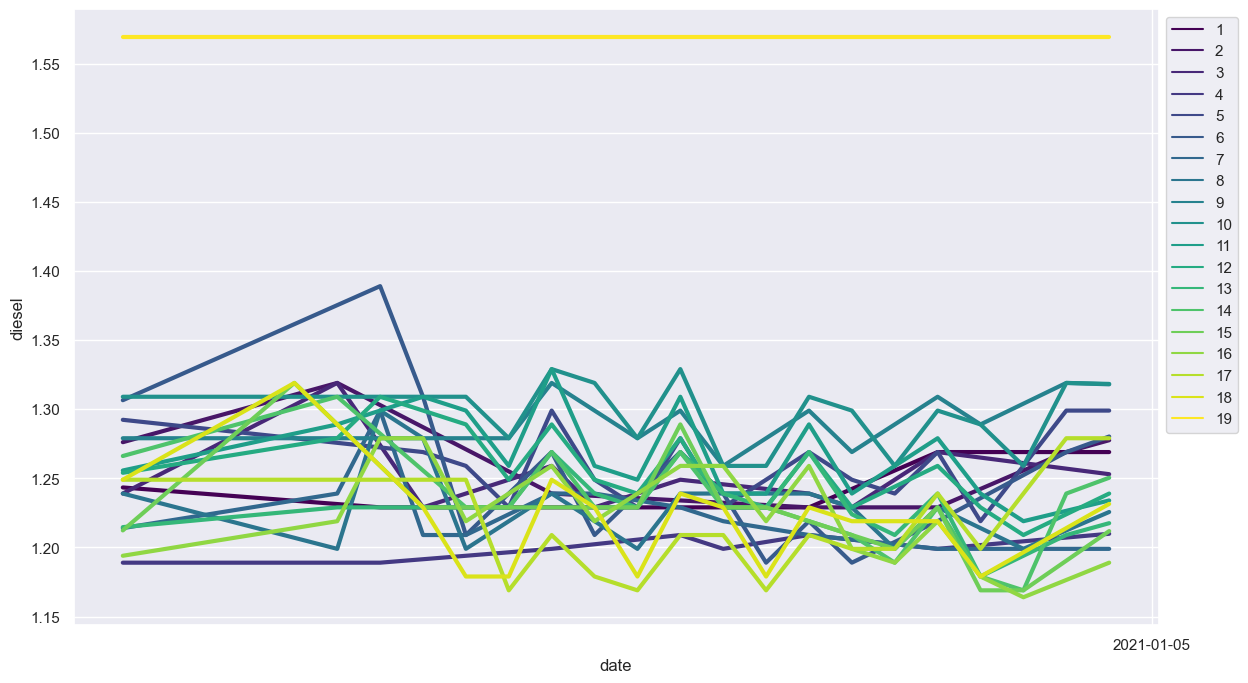

In [45]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=aggdf2[aggdf2['date'].dt.strftime('%Y-%m-%d') == '2021-01-04'], x ='date', y = 'diesel',
                  hue='station_uuid', palette='viridis',
                  legend='full', lw=3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('diesel')
plt.xlabel('date')
plt.savefig('dayvaluediesel.svg')
plt.show()

In [46]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=aggdf2[aggdf2['date'].dt.strftime('%Y-%m-%d') == '2021-01-04'], x ='date', y = 'e5',
                  hue='station_uuid', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('e5')
plt.xlabel('date')
plt.savefig('dayvaluee5.svg')
plt.show()

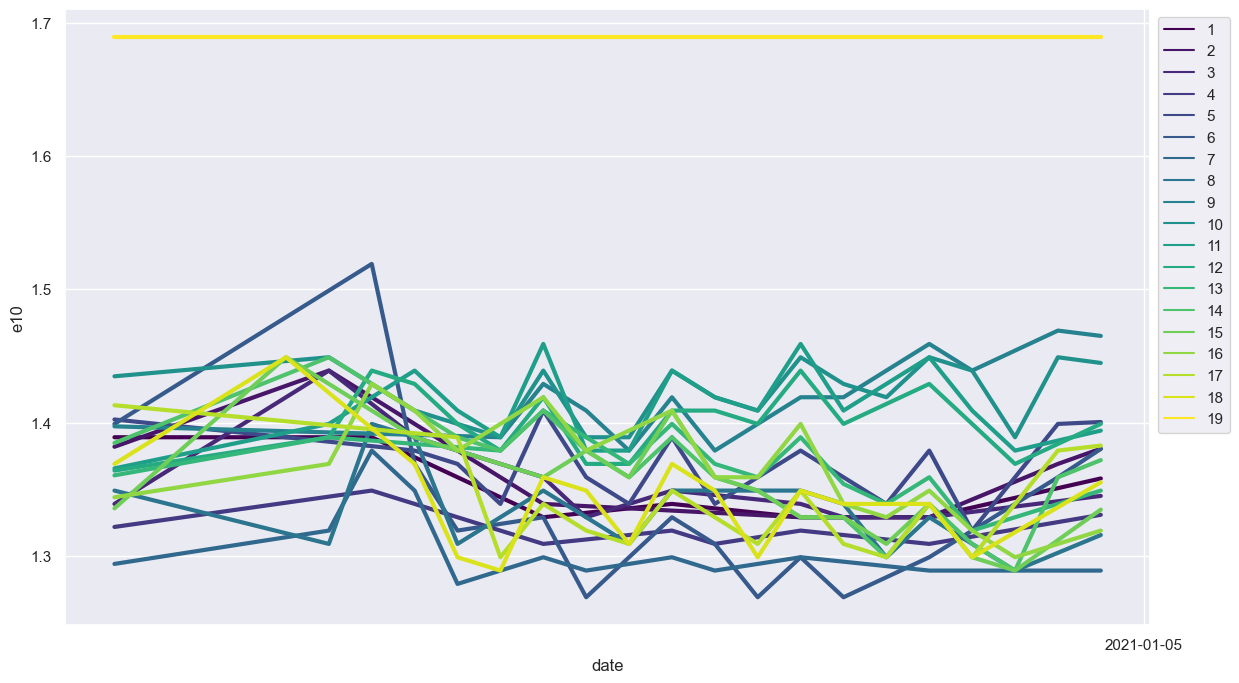

In [47]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=aggdf2[aggdf2['date'].dt.strftime('%Y-%m-%d') == '2021-01-04'], x ='date', y = 'e10',
                  hue='station_uuid', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('e10')
plt.xlabel('date')
plt.savefig('dayvaluee10.svg')
plt.show()

In [48]:
aggdf2.describe()

station_uuid         diesel             e5            e10
count  166440.000000  166440.000000  166440.000000  166440.000000
mean       10.000000       1.421717       1.618663       1.560109
std         5.477242       0.120945       0.116522       0.116111
min         1.000000       1.139000       1.309000       1.259000
25%         5.000000       1.329000       1.539000       1.479000
50%        10.000000       1.399000       1.617750       1.557661
75%        15.000000       1.519000       1.694000       1.634000
max        19.000000       1.829000       1.969000       1.919000

In [49]:
aggdf2

date  station_uuid  diesel        e5       e10
0      2021-01-01 00:00:00+00:00             1   1.259  1.399000  1.349000
1      2021-01-01 01:00:00+00:00             1   1.259  1.400429  1.350429
2      2021-01-01 02:00:00+00:00             1   1.259  1.401857  1.351857
3      2021-01-01 03:00:00+00:00             1   1.259  1.403286  1.353286
4      2021-01-01 04:00:00+00:00             1   1.259  1.404714  1.354714
...                          ...           ...     ...       ...       ...
166435 2021-12-31 19:00:00+00:00            19   1.759  1.969000  1.919000
166436 2021-12-31 20:00:00+00:00            19   1.759  1.969000  1.919000
166437 2021-12-31 21:00:00+00:00            19   1.759  1.969000  1.919000
166438 2021-12-31 22:00:00+00:00            19   1.759  1.969000  1.919000
166439 2021-12-31 23:00:00+00:00            19   1.759  1.969000  1.919000

[166440 rows x 5 columns]

In [50]:
aggdf3 = aggdf2.groupby([aggdf2['station_uuid'],aggdf2['date'].dt.date]).mean()

C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\1727753404.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggdf3 = aggdf2.groupby([aggdf2['station_uuid'],aggdf2['date'].dt.date]).mean()


In [51]:
aggdf3 = aggdf3[['diesel', 'e5', 'e10']].reset_index()

In [52]:
g = sns.FacetGrid(aggdf3, col='station_uuid', hue='station_uuid', col_wrap=4, )
g.set_xticklabels(labels=None)
# Add the line over the area with the plot function
g.map(plt.plot, 'date', 'diesel')
 
# Fill the area with fill_between
g.map(plt.fill_between, 'date', 'diesel', alpha=0.4).set_titles("{col_name} station_uuid")
 
# Control the title of each facet
g.set_titles("{col_name}")
 
# Add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of diesel prices date 01/01/2021-31/12/2021')
g.savefig('facetdiesel.svg')
# Show the graph
plt.show()


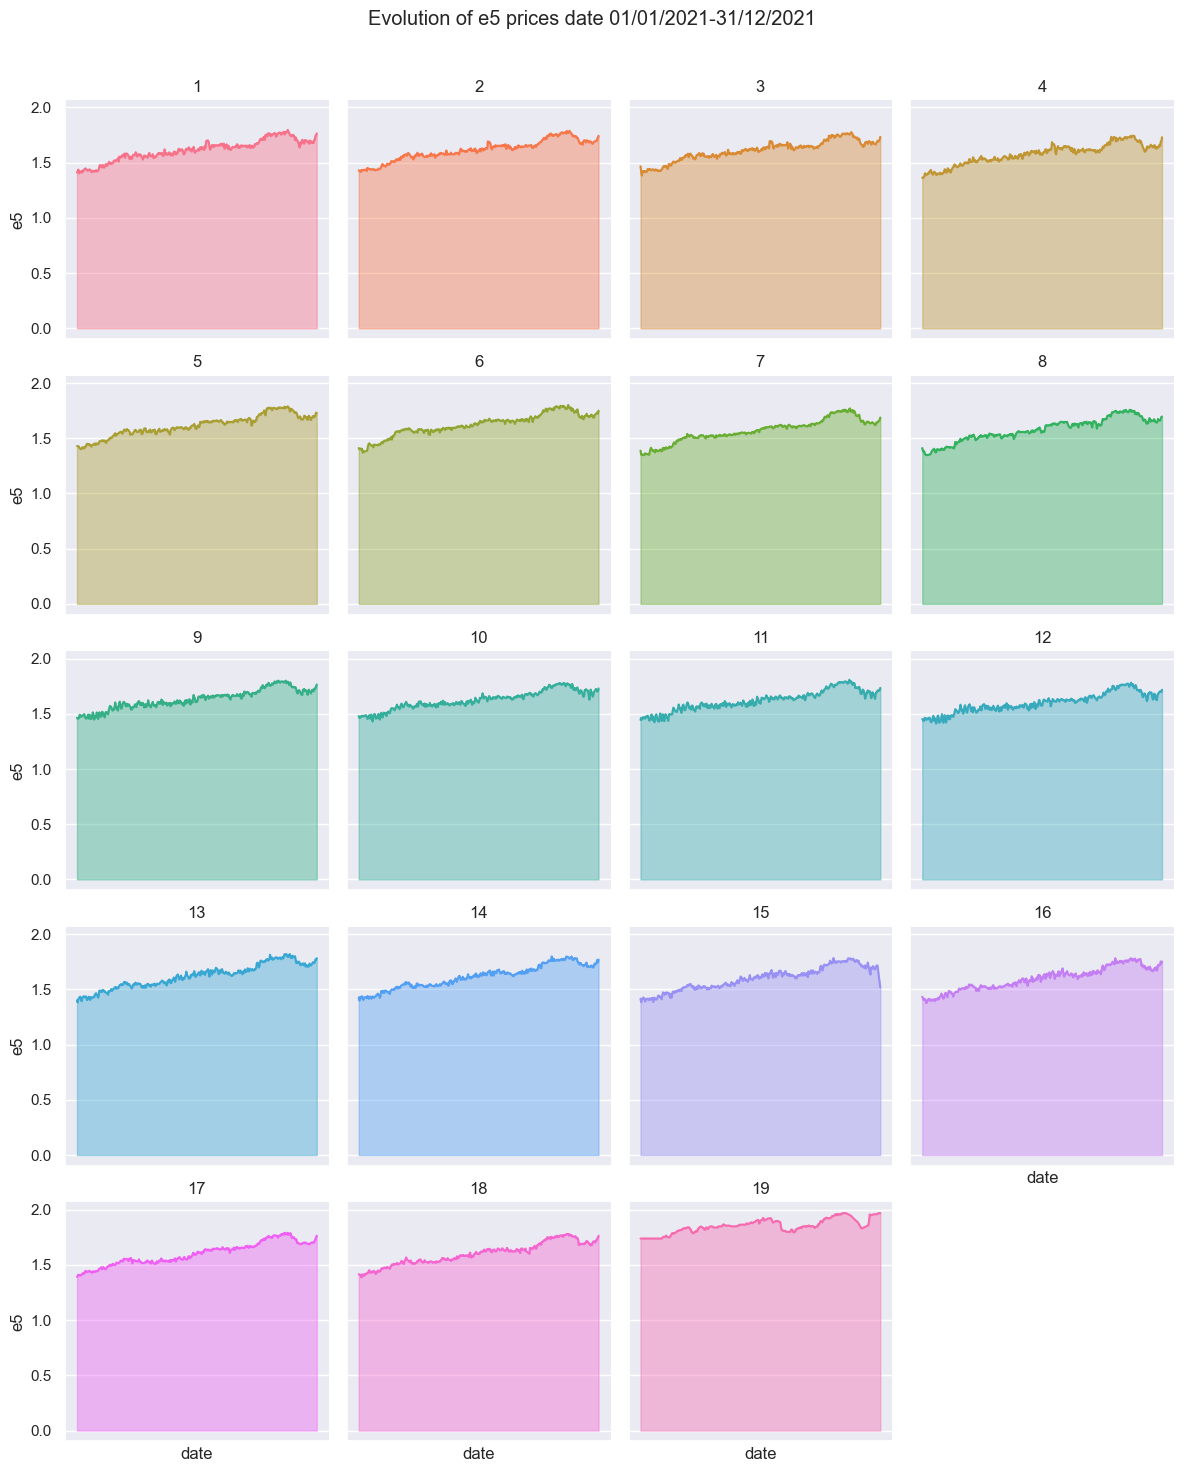

In [53]:
g = sns.FacetGrid(aggdf3, col='station_uuid', hue='station_uuid', col_wrap=4, )
g.set_xticklabels(labels=None)
g.map(plt.plot, 'date', 'e5')
 

g.map(plt.fill_between, 'date', 'e5', alpha=0.4).set_titles("{col_name} station_uuid")
 
g.set_titles("{col_name}")


plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of e5 prices date 01/01/2021-31/12/2021')
g.savefig('facete5.svg')
plt.show()


In [54]:
g = sns.FacetGrid(aggdf3, col='station_uuid', hue='station_uuid', col_wrap=4, )
g.set_xticklabels(labels=None)
g.map(plt.plot, 'date', 'e10')
 

g.map(plt.fill_between, 'date', 'e10', alpha=0.4).set_titles("{col_name} station_uuid")
 
g.set_titles("{col_name}")


plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of e10 prices date 01/01/2021-31/12/2021')
g.savefig('facete10.svg')
plt.show()

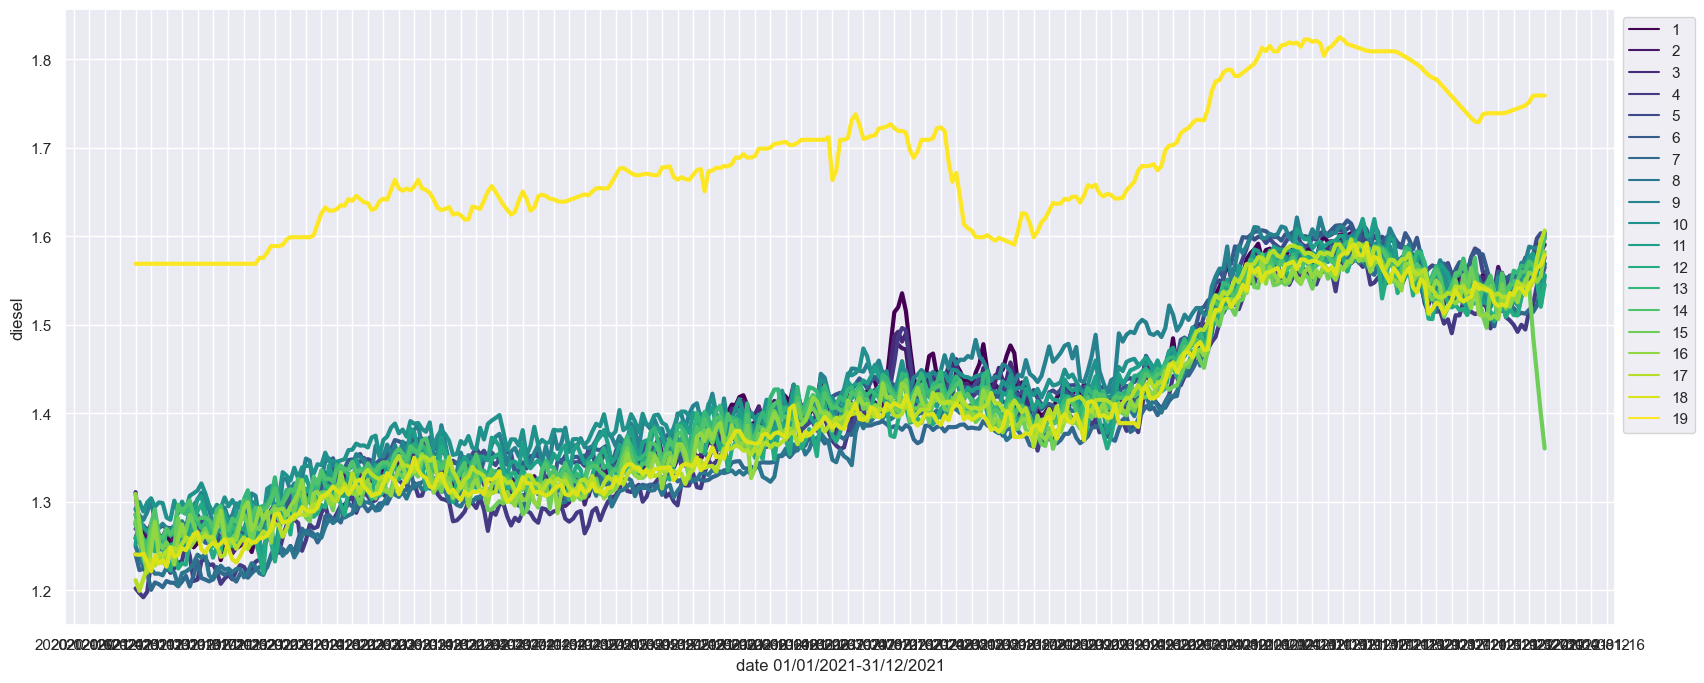

In [55]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20,8)})
ax = sns.lineplot(data=aggdf3, x ='date', y = 'diesel',
                  hue='station_uuid', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('diesel')
plt.xlabel('date 01/01/2021-31/12/2021')
plt.savefig('aggregatedoverdaydiesel.svg')
plt.show()

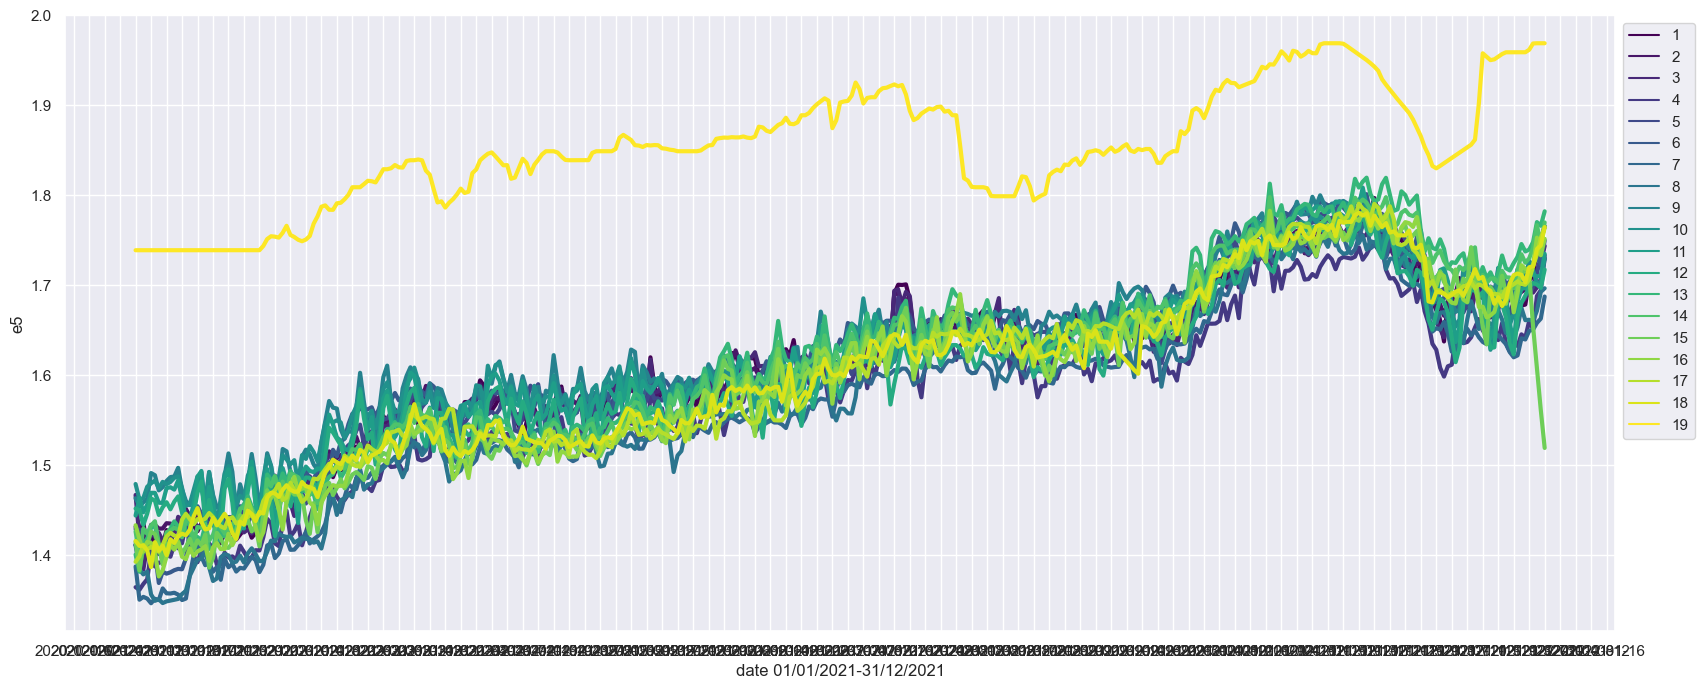

In [56]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20,8)})

# ax = sns.lineplot(data=aggdf2[aggdf2['date'].dt.month ==2], x ='date', y = 'diesel',
#                   hue='station_uuid', palette='viridis',
#                   legend='full', lw=3)

ax = sns.lineplot(data=aggdf3, x ='date', y = 'e5',
                  hue='station_uuid', palette='viridis',
                  legend='full', lw=3)
# ax = sns.lineplot(data=df, x ='date', y = 'diesel',
#                   hue='station_uuid', palette='viridis',
#                   legend='full', lw=3)
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('e5')
plt.xlabel('date 01/01/2021-31/12/2021')
plt.savefig('aggregatedoverdaye5.svg')
plt.show()

In [57]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20,8)})
ax = sns.lineplot(data=aggdf3, x ='date', y = 'e10',
                  hue='station_uuid', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('e10')
plt.xlabel('date 01/01/2021-31/12/2021')
plt.savefig('aggregatedoverdaye10.svg')
plt.show()

On the first looks we can conclude that price trend is close on each station so we proceed with exploratory analysis on one station 

Seasonal decompose shows a clear trend of increase in price

Text(0.5, 1.0, 'residual')

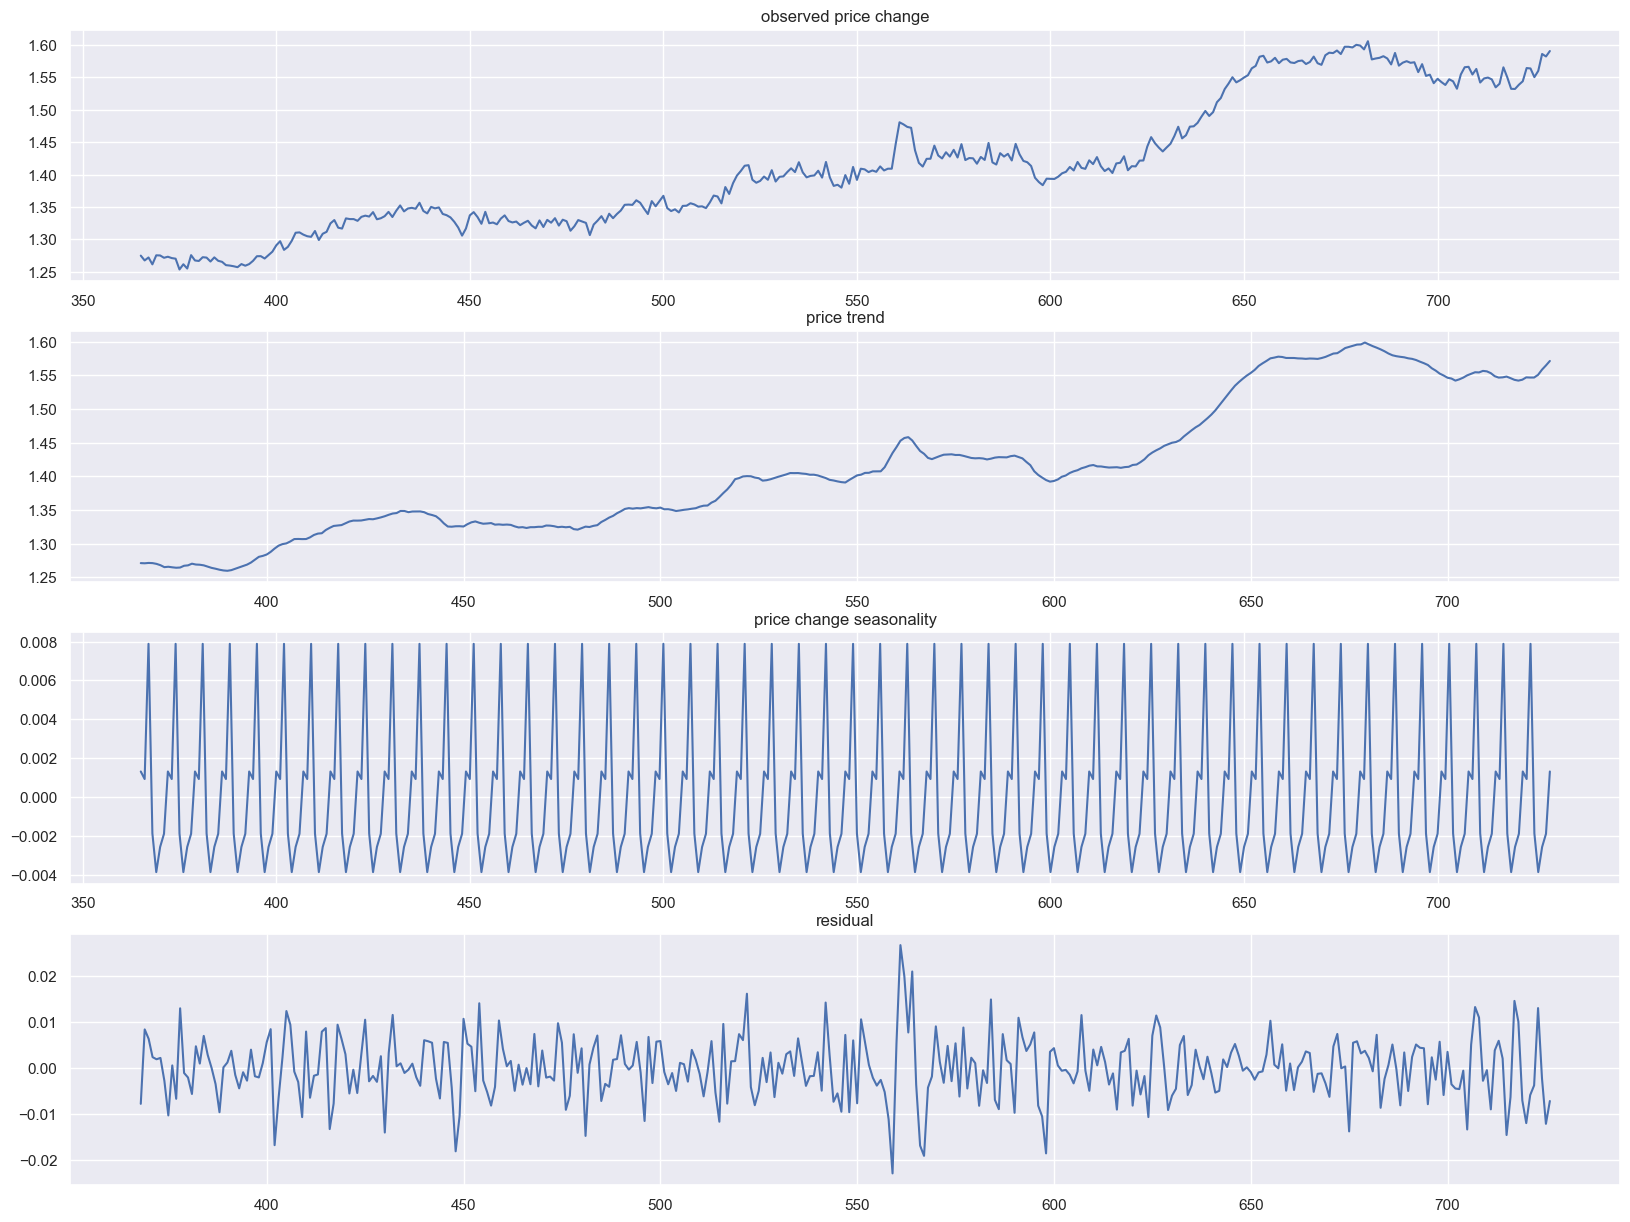

In [58]:
plt.figure(figsize=(20,15))

#decompose series and plot
r = seasonal_decompose(aggdf3[aggdf3.station_uuid==2].diesel, model='additive',period =7)
plt.subplot(4,1,1)
r.observed.plot()
plt.title('observed price change')
plt.subplot(4,1,2)
r.trend.plot()
plt.title('price trend')
plt.subplot(4,1,3)
r.seasonal.plot()
plt.title('price change seasonality')
plt.subplot(4,1,4)
r.resid.plot()
plt.title('residual')

Text(0.5, 1.0, 'residual')

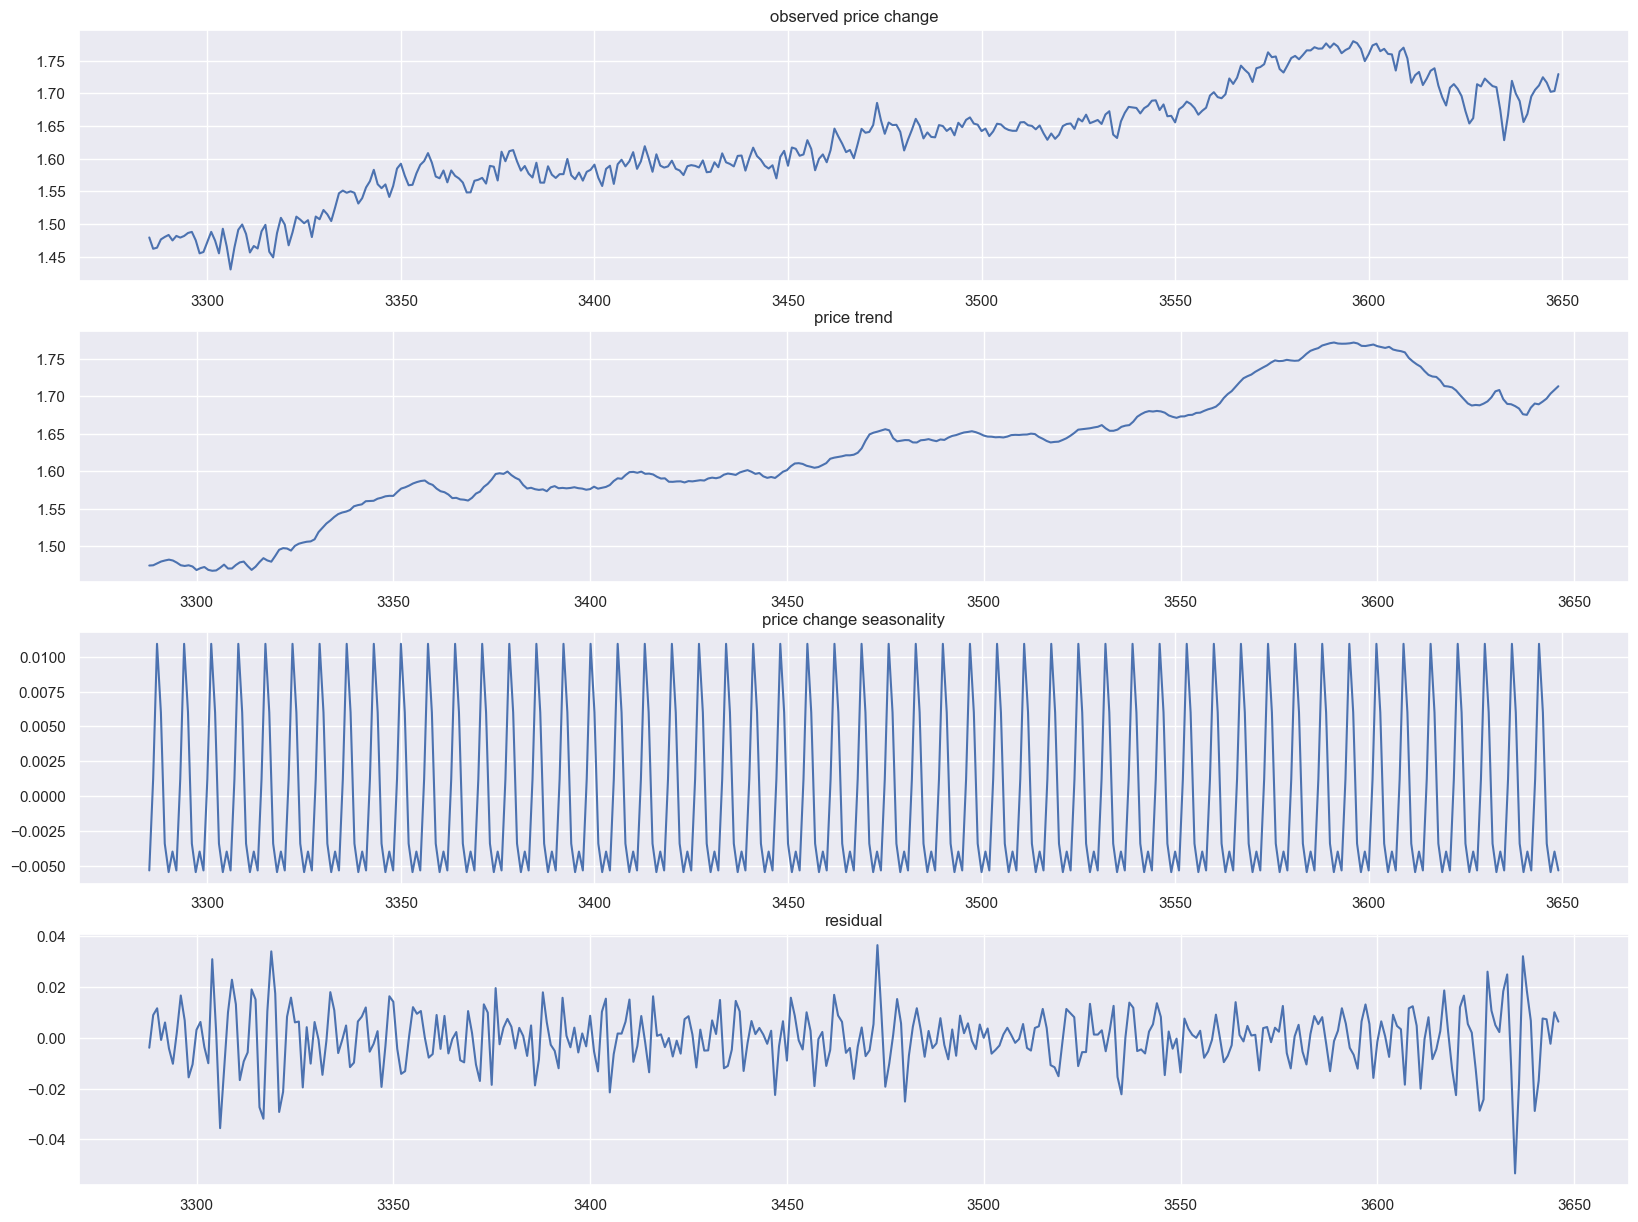

In [59]:
plt.figure(figsize=(20,15))

#decompose series and plot
r = seasonal_decompose(aggdf3[aggdf3.station_uuid==10].e5, model='additive',period =7)
plt.subplot(4,1,1)
r.observed.plot()
plt.title('observed price change')
plt.subplot(4,1,2)
r.trend.plot()
plt.title('price trend')
plt.subplot(4,1,3)
r.seasonal.plot()
plt.title('price change seasonality')
plt.subplot(4,1,4)
r.resid.plot()
plt.title('residual')

Text(0.5, 1.0, 'residual')

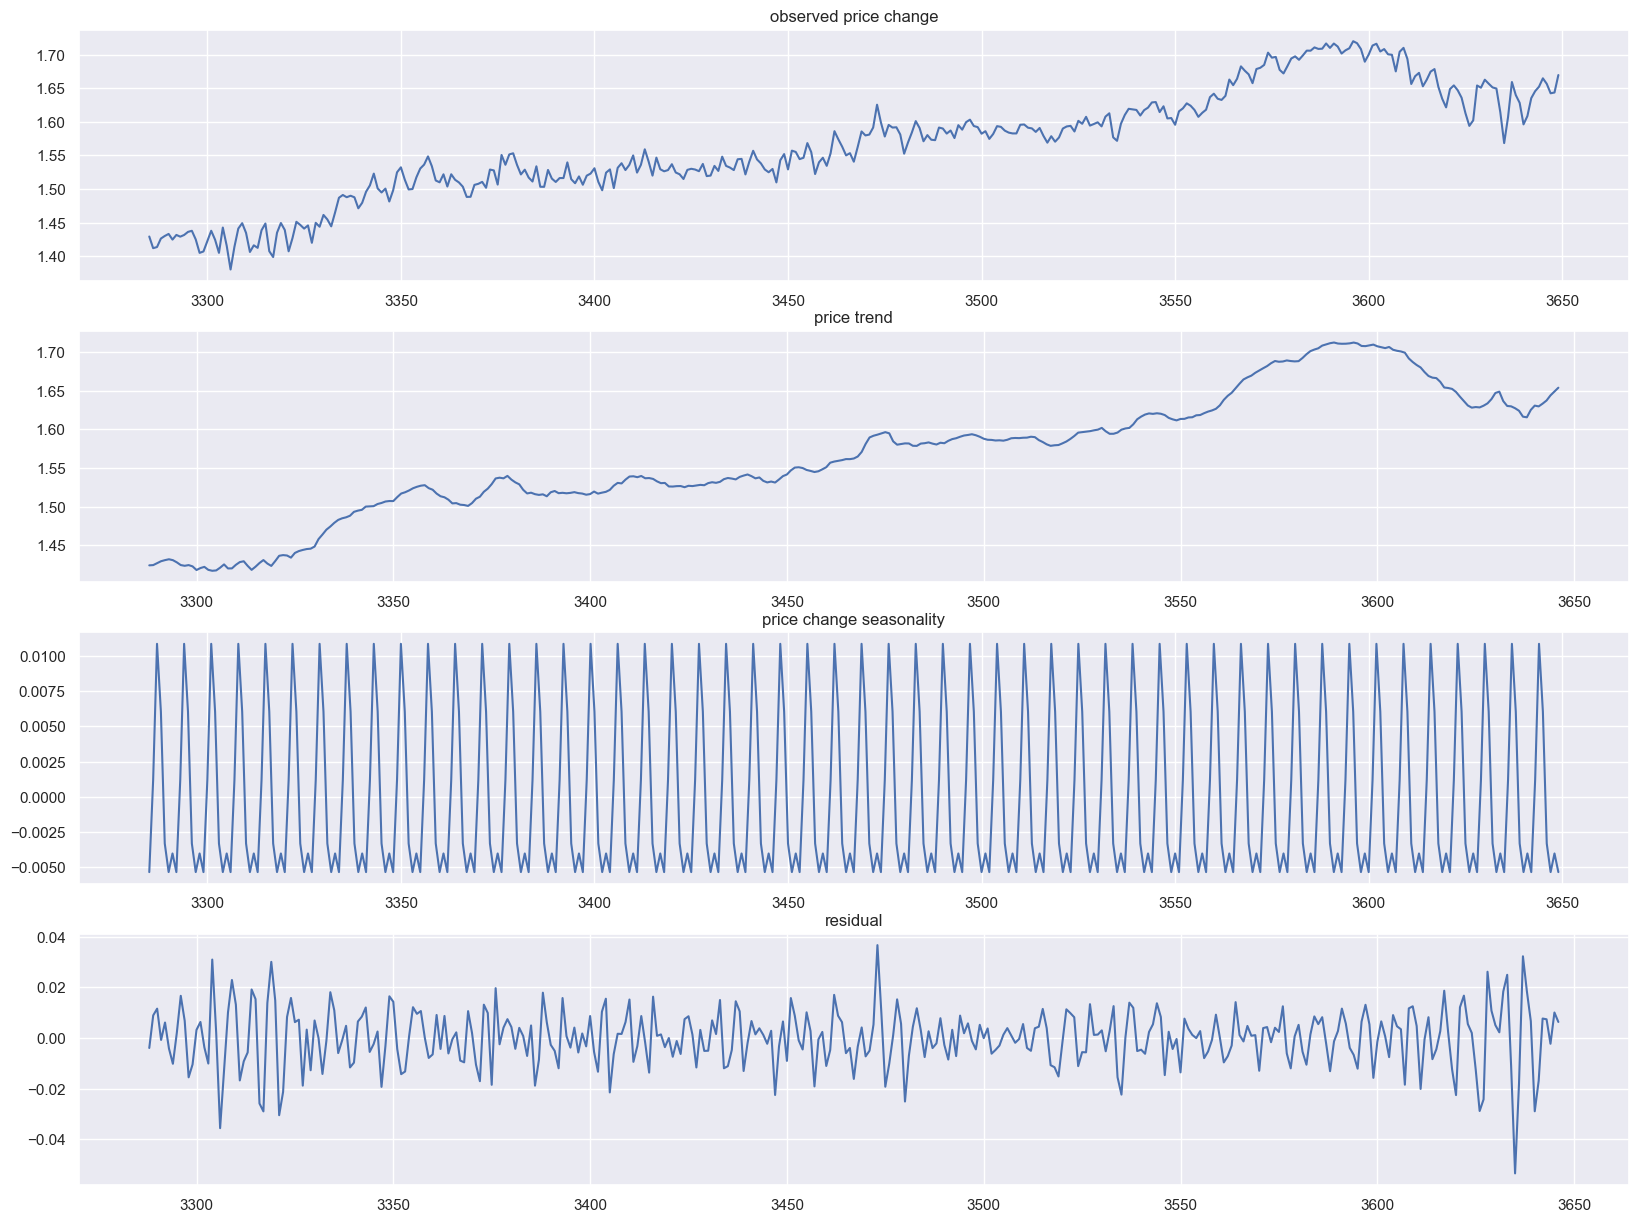

In [60]:
plt.figure(figsize=(20,15))

#decompose series and plot
r = seasonal_decompose(aggdf3[aggdf3.station_uuid==10].e10, model='additive',period =7)
plt.subplot(4,1,1)
r.observed.plot()
plt.title('observed price change')
plt.subplot(4,1,2)
r.trend.plot()
plt.title('price trend')
plt.subplot(4,1,3)
r.seasonal.plot()
plt.title('price change seasonality')
plt.subplot(4,1,4)
r.resid.plot()
plt.title('residual')

Rolling mean and standard deviation to observe the trend and volaitlity of price fluctuations for a rolling window of 24 hrs
 


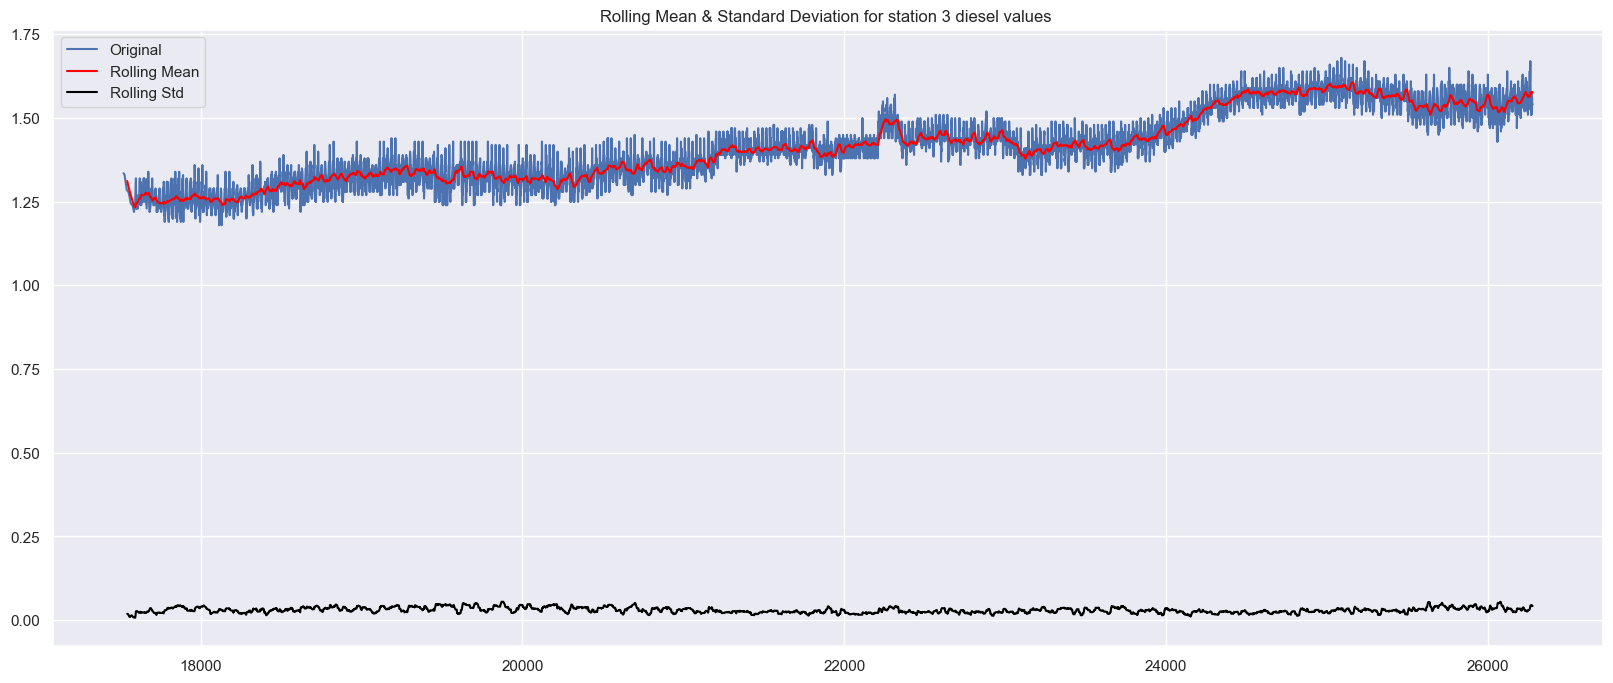

In [61]:
rolmean = aggdf2[aggdf2.station_uuid==3].diesel.rolling(window=24).mean()
rolstd = aggdf2[aggdf2.station_uuid==3].diesel.rolling(window=24).std()

# Plot rolling statistics:
orig = plt.plot(aggdf2[aggdf2.station_uuid==3].diesel, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation for station 3 diesel values ')
plt.savefig('rollingmeanandstd.svg')
plt.show(block=False)


In [62]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# f, axarr = plt.subplots(19,2,figsize=(100,100))
# import statsmodels.api as sm

# for n in range(aggdf2['station_uuid'].nunique()):
#   plot_acf(aggdf2[aggdf2.station_uuid==n+1].diesel, lags=72,ax =axarr[n,0])
#   plot_pacf(aggdf2[aggdf2.station_uuid== n+1].diesel, lags=72,ax =axarr[n,1])
# plt.show()
# f.savefig('correlationplots.png')

Plotting Auto corelation function and partial auto corelation functions

d:\PP\envs\augmixenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


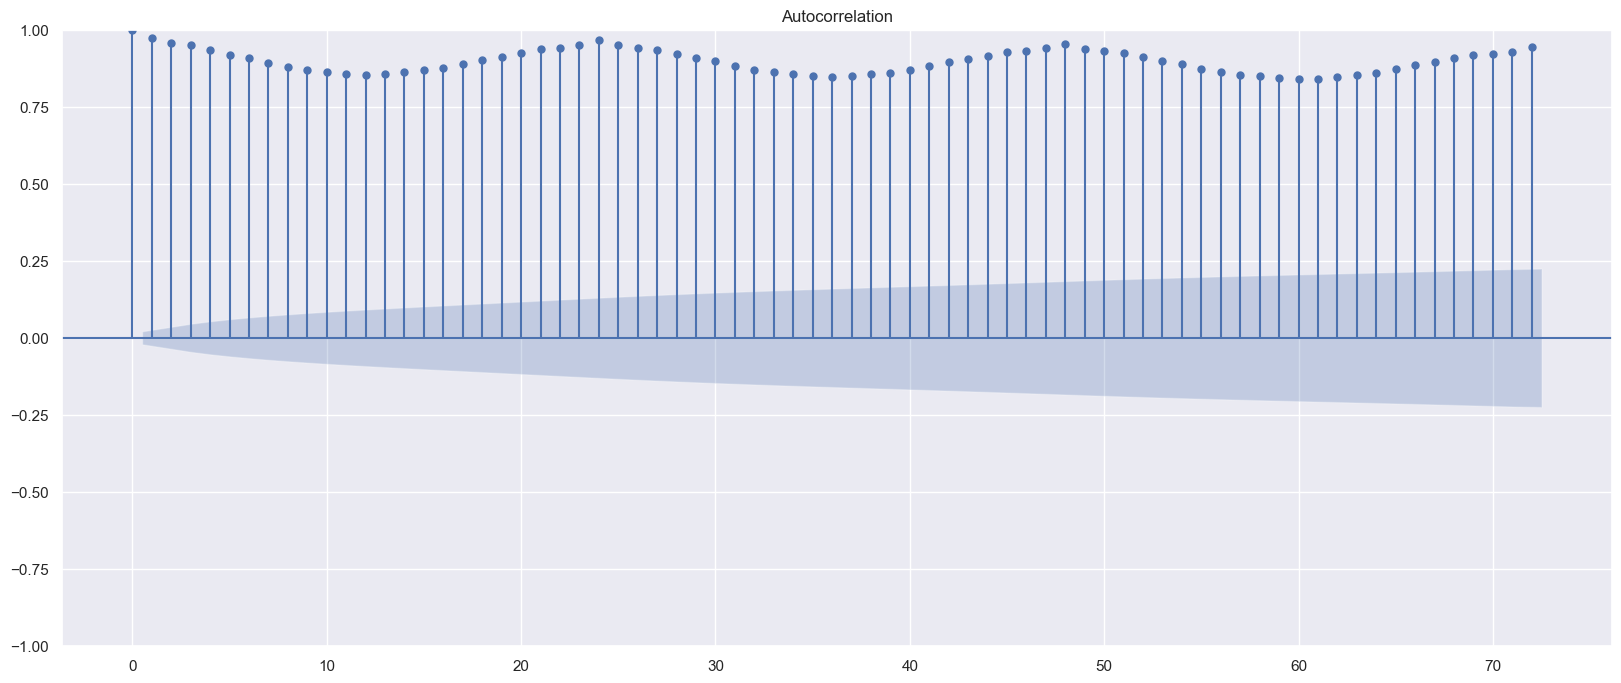

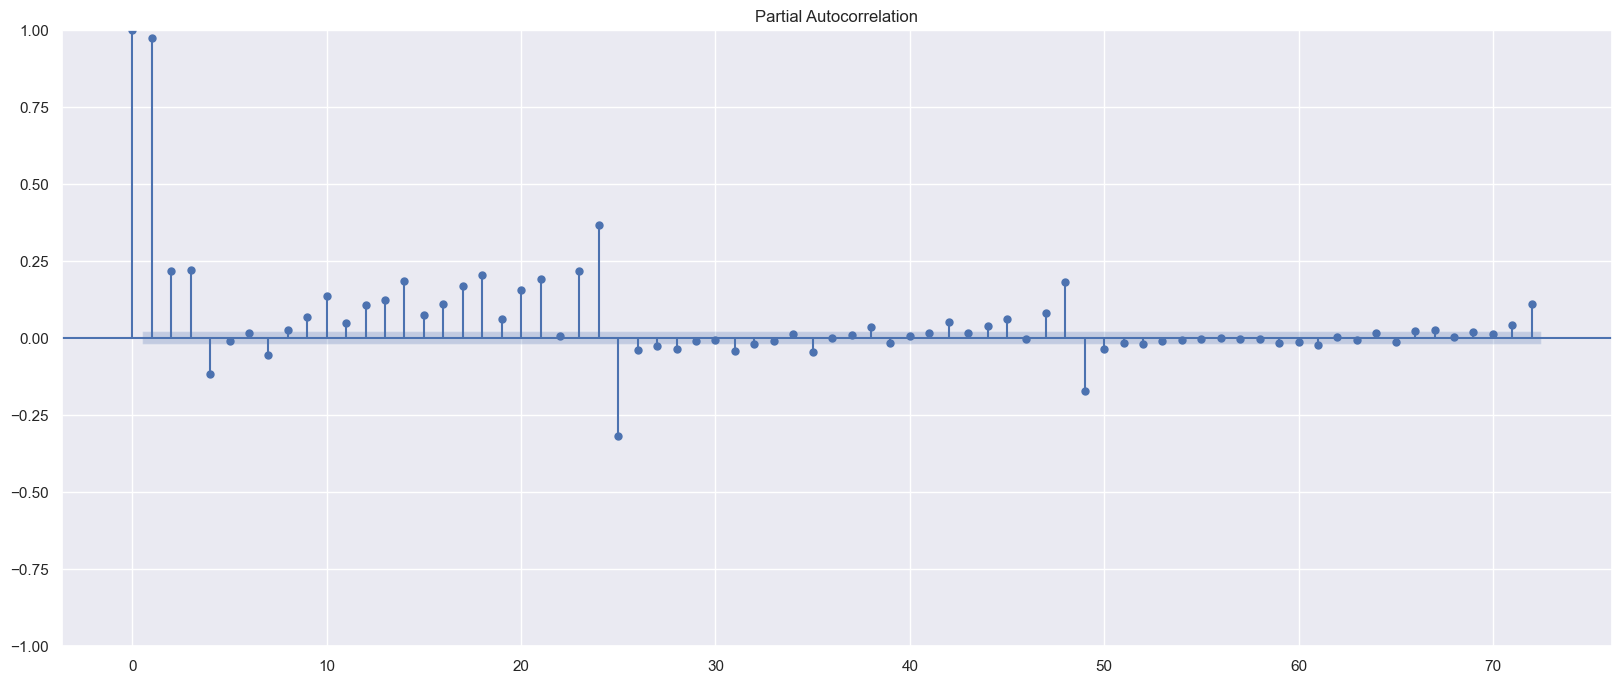

In [63]:
plot_acf(aggdf2[aggdf2.station_uuid==2].diesel, lags=72)
plt.savefig('acf.svg')
plot_pacf(aggdf2[aggdf2.station_uuid==2].diesel, lags=72)
plt.savefig('pacf.svg')
plt.show()

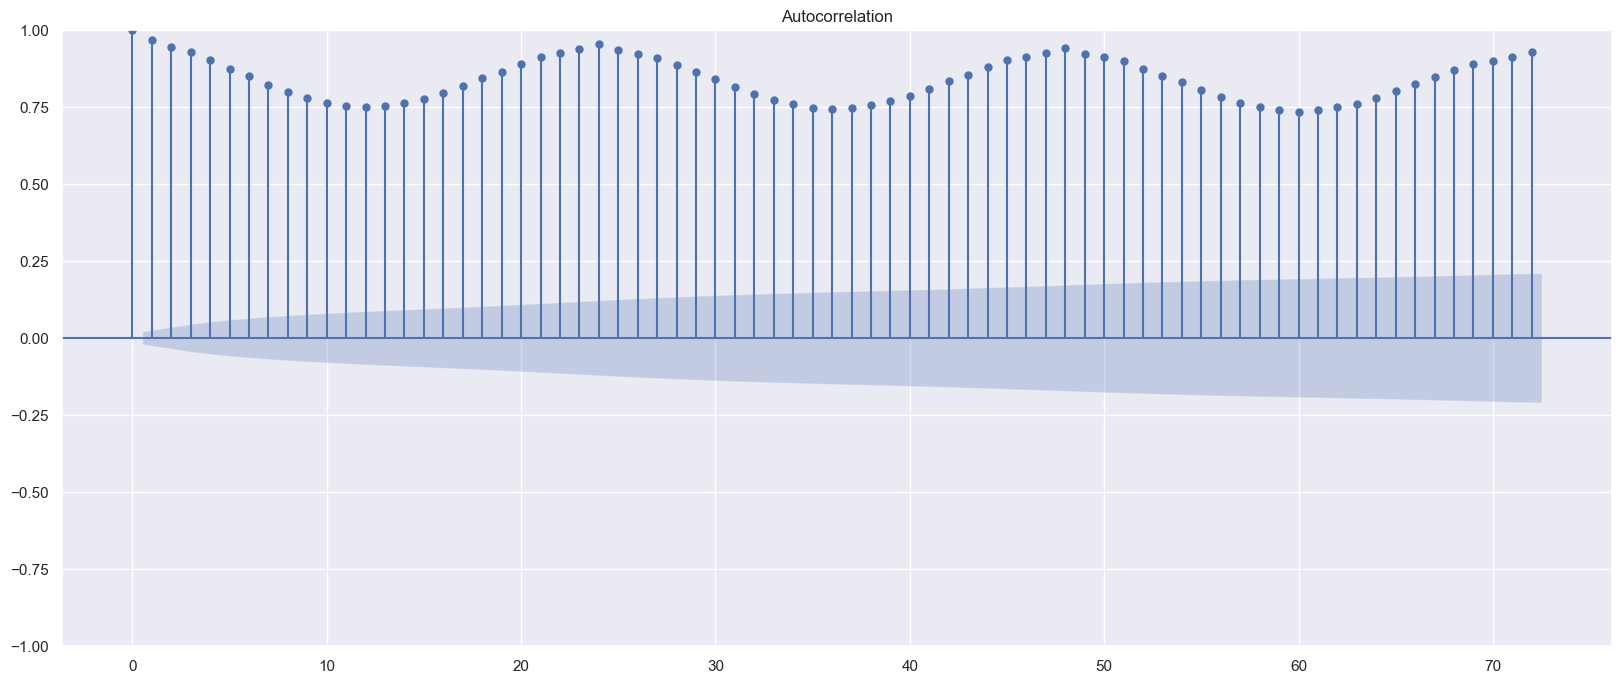

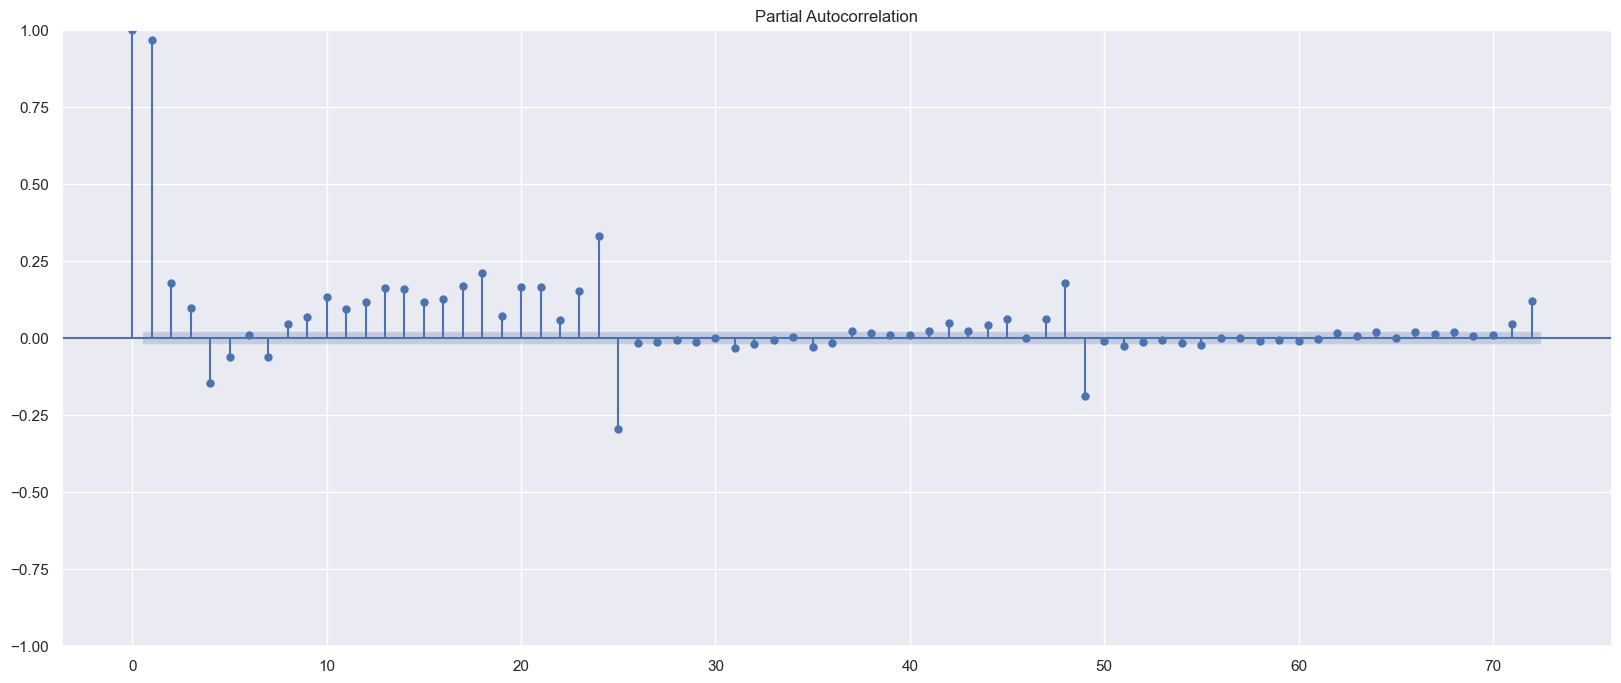

In [64]:
plot_acf(aggdf2[aggdf2.station_uuid==2].e5, lags=72)
plt.savefig('acf.svg')
plot_pacf(aggdf2[aggdf2.station_uuid==2].e5, lags=72)
plt.savefig('pacf.svg')
plt.show()


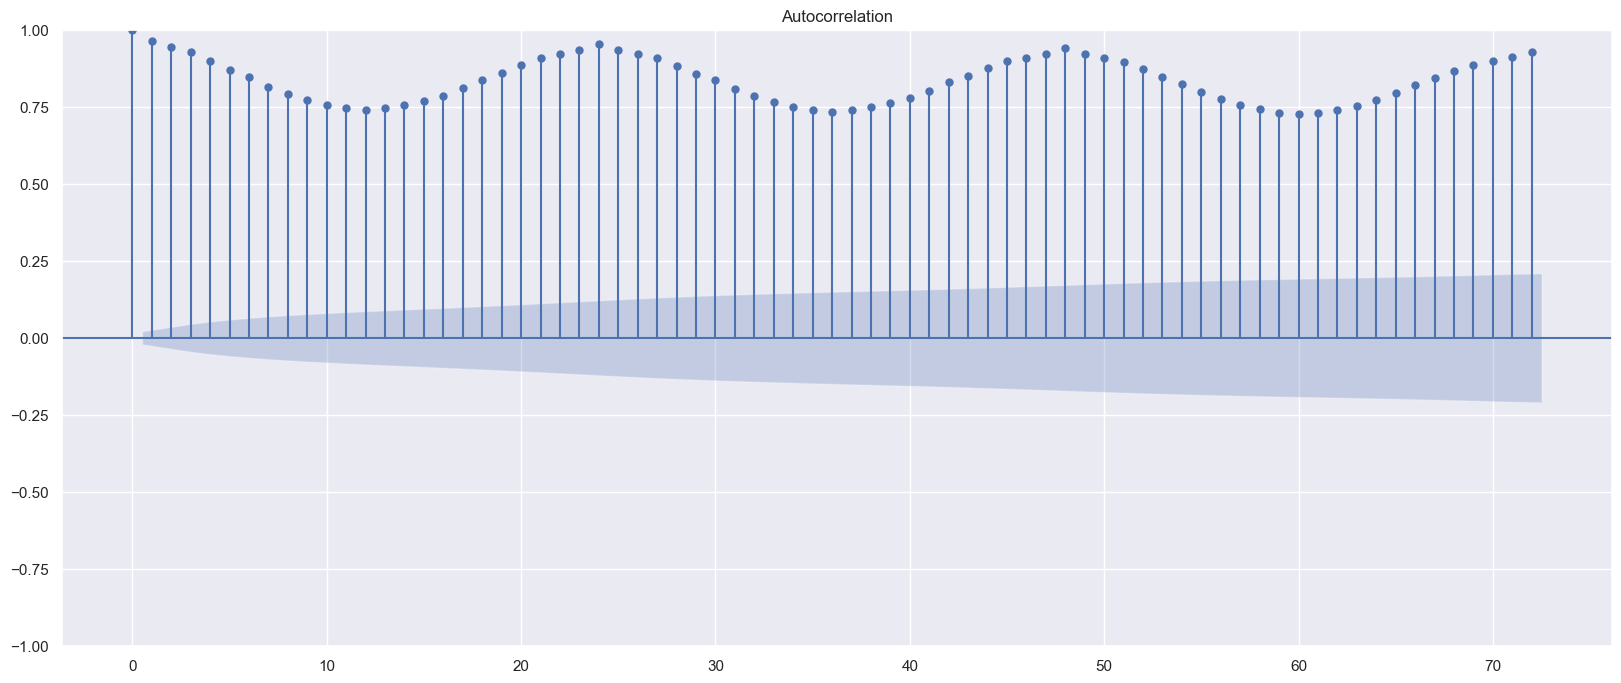

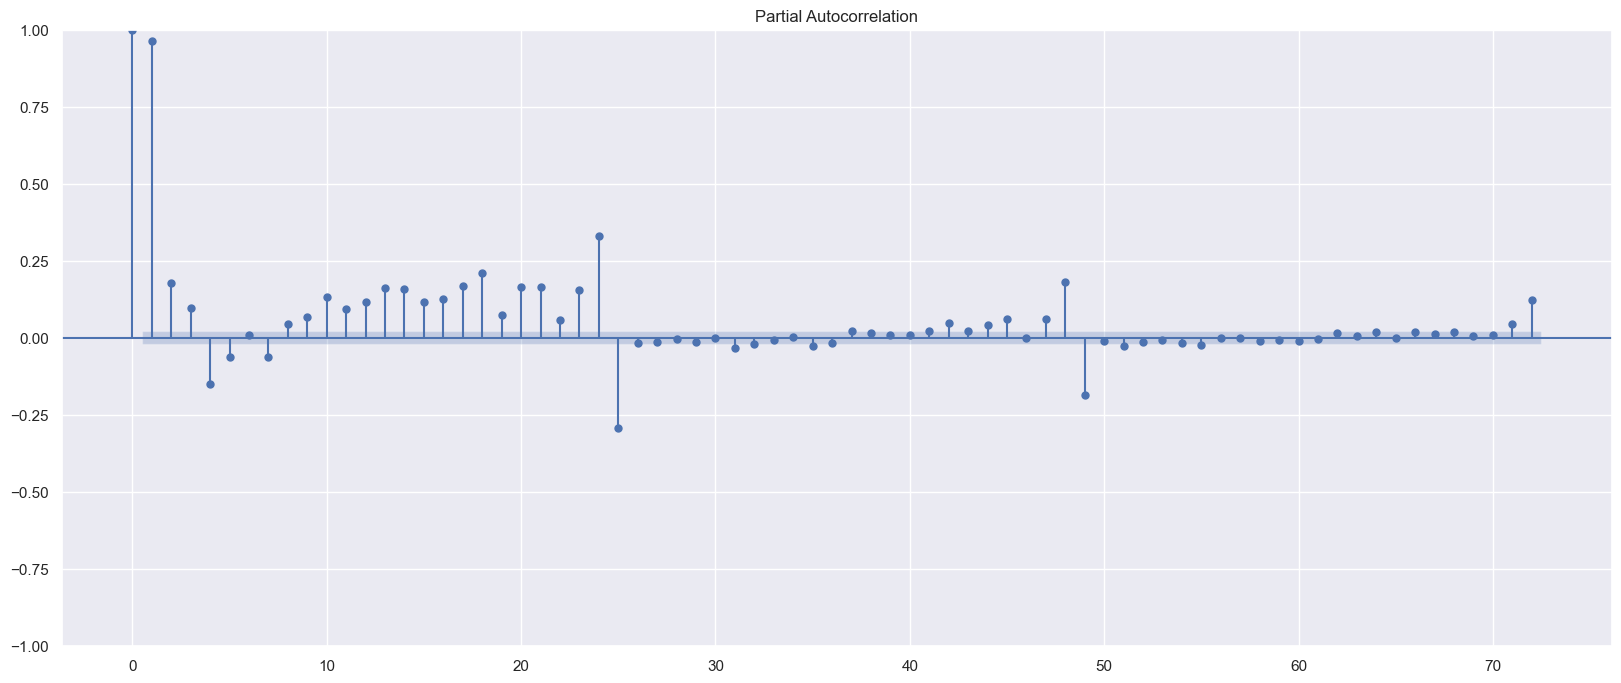

In [65]:
plot_acf(aggdf2[aggdf2.station_uuid==2].e10, lags=72)
plt.savefig('acf.svg')
plot_pacf(aggdf2[aggdf2.station_uuid==2].e10, lags=72)
plt.savefig('pacf.svg')
plt.show()

We can observe strong corelation between prices of each hour and trend in a day

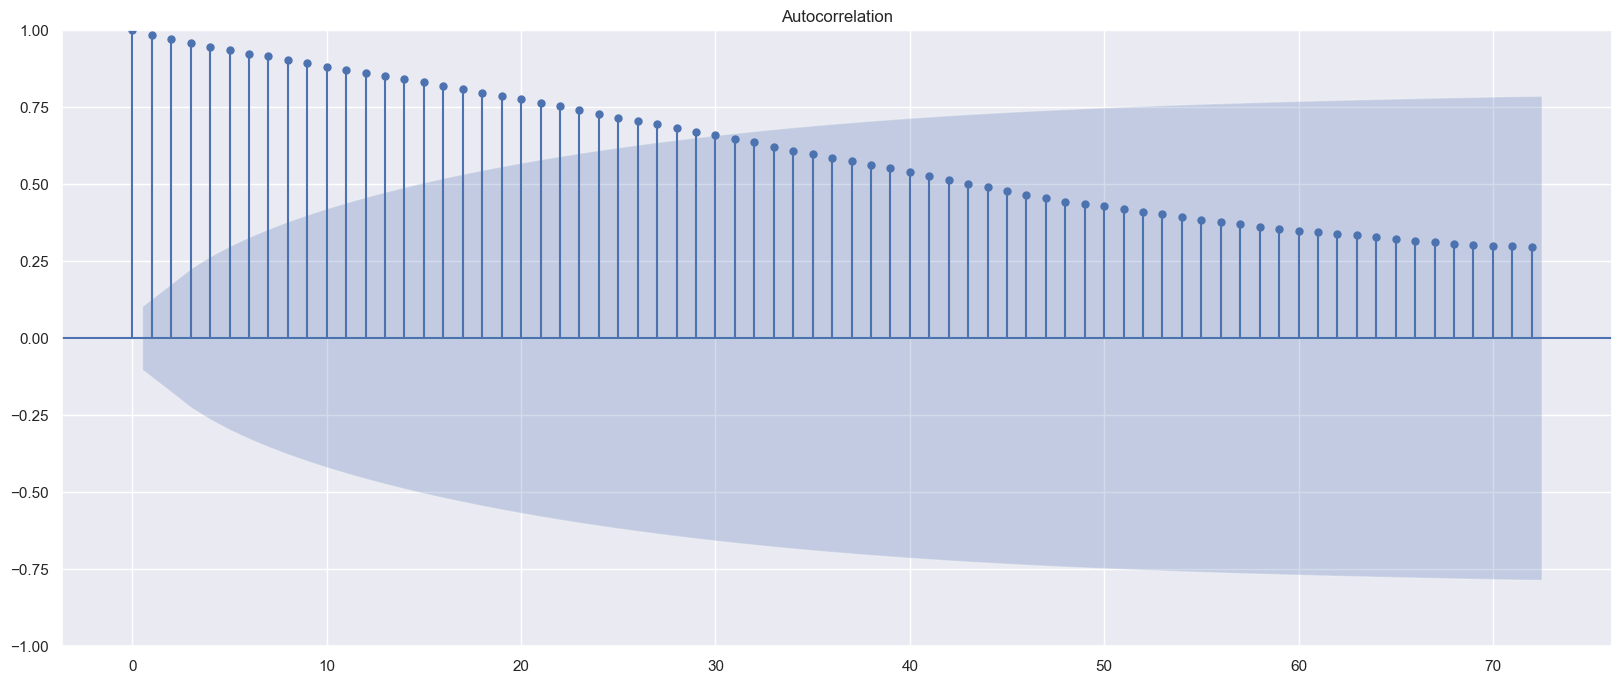

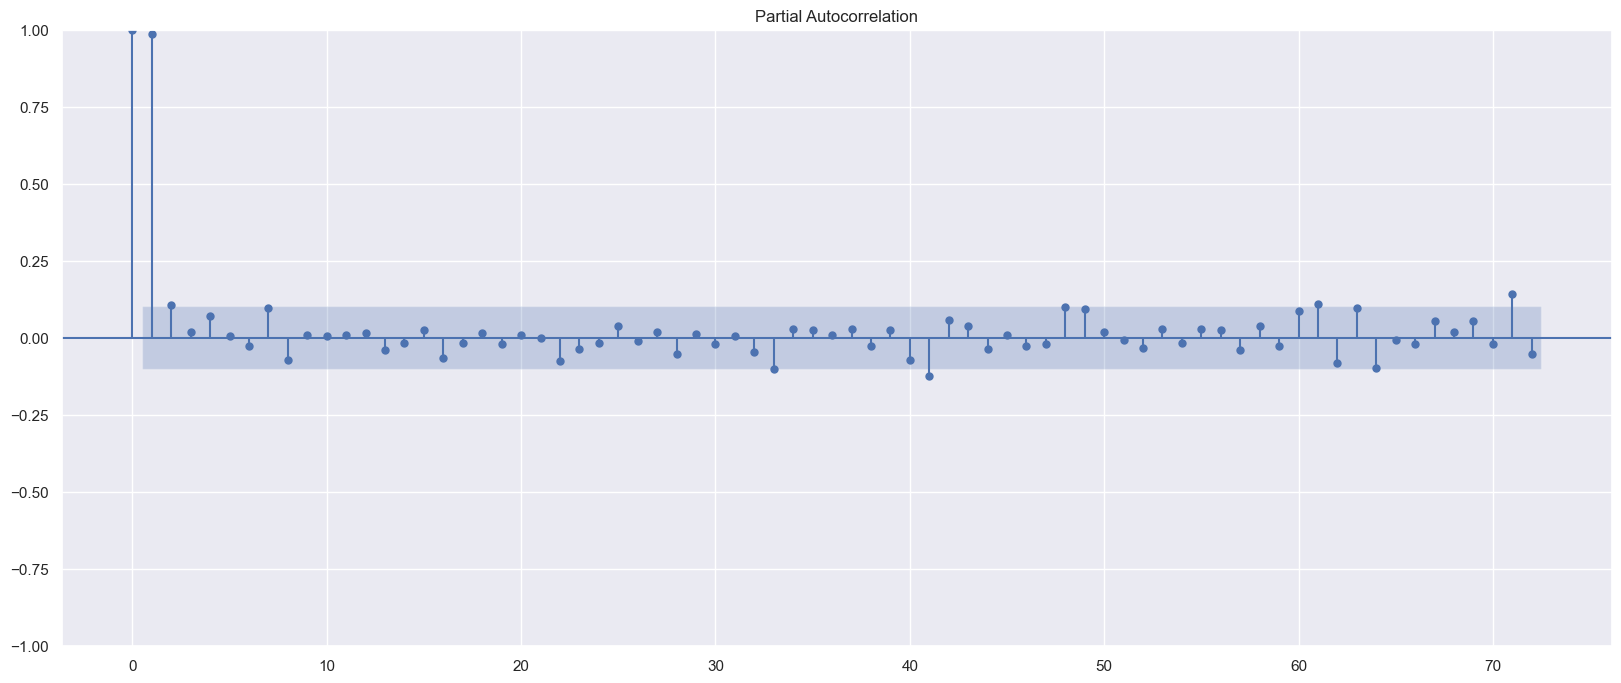

In [66]:
plot_acf(aggdf3[aggdf3.station_uuid==3].e5, lags=72)
plt.savefig('acfmean.svg')
plot_pacf(aggdf3[aggdf3.station_uuid==3].e5, lags=72)
plt.savefig('pacfmean.svg')
plt.show()

Task 2 prediction

I have decided to use 2 models to make the hourly predictions on the data and ensemble the outputs 

*   Autoreg model to predict average daily value on mean values of each day 
*   non-linear lightGBM model trained on hourly data to learn the daily trend of the data

Later the prediction values are ensembled to make the final prediction value

Now training on Autreg model to predict the average value for each day

In [67]:
df_training = aggdf3
print(f"{len(df_training)} days of training data )")

6935 days of training data )


Fitting Autoreg model for lags of 30 and forecasting one day at a time 

The models are fitted on each station id and each fuel type seperately a total of 57 models are fitted and predictions are made 

In [68]:
predictionsdiesel=pd.DataFrame([])
for n in range(df_training['station_uuid'].nunique()):
  df_training_station = df_training[df_training.station_uuid==n+1]
  df_training_station = df_training_station.set_index('date')
  #order = orderdict['station_uuid'+str(n)]
  for d in range(5):
    mod = AutoReg(df_training_station.diesel,lags = 30) #instantiating model 
    model_fit = mod.fit()                               #fitting model
    yhat = model_fit.forecast()                         #forecasting value for a day 
    y = pd.DataFrame(yhat)
    y.columns = ['diesel' if x==0 else x for x in y.columns]
    df_training_station = pd.concat([df_training_station,y])  #updating the train dataset 
  predictionsdiesel[str(n+1)] = df_training_station['diesel'].tail(5)

d:\PP\envs\augmixenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\PP\envs\augmixenv\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
d:\PP\envs\augmixenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\PP\envs\augmixenv\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the

In [69]:
predictionse5=pd.DataFrame([])
for n in range(df_training['station_uuid'].nunique()):
  df_training_station = df_training[df_training.station_uuid==n+1]
  df_training_station = df_training_station.set_index('date')
  #order = orderdict['station_uuid'+str(n)]
  for d in range(5):
    mod = AutoReg(df_training_station.e5,lags=30)   #instantiating model 
    model_fit = mod.fit()                           #fitting model
    yhat = model_fit.forecast()                     #forecasting value for a day 
    y = pd.DataFrame(yhat)
    y.columns = ['e5' if x==0 else x for x in y.columns]
    df_training_station = pd.concat([df_training_station,y])    #updating the train dataset 
  predictionse5[str(n+1)] = df_training_station['e5'].tail(5)

d:\PP\envs\augmixenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\PP\envs\augmixenv\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
d:\PP\envs\augmixenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\PP\envs\augmixenv\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the

In [70]:
predictionse10=pd.DataFrame([])
for n in range(df_training['station_uuid'].nunique()):
  df_training_station = df_training[df_training.station_uuid==n+1]
  df_training_station = df_training_station.set_index('date')
  #order = orderdict['station_uuid'+str(n)]
  for d in range(5):
    mod = AutoReg(df_training_station.e10,lags = 30)            #instantiating model 
    model_fit = mod.fit()                                       #fitting model
    yhat = model_fit.forecast()                                  #forecasting value for a day 
    y = pd.DataFrame(yhat)
    y.columns = ['e10' if x==0 else x for x in y.columns]
    df_training_station = pd.concat([df_training_station,y])      #updating the train dataset 
  predictionse10[str(n+1)] = df_training_station['e10'].tail(5)

d:\PP\envs\augmixenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\PP\envs\augmixenv\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
d:\PP\envs\augmixenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\PP\envs\augmixenv\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the

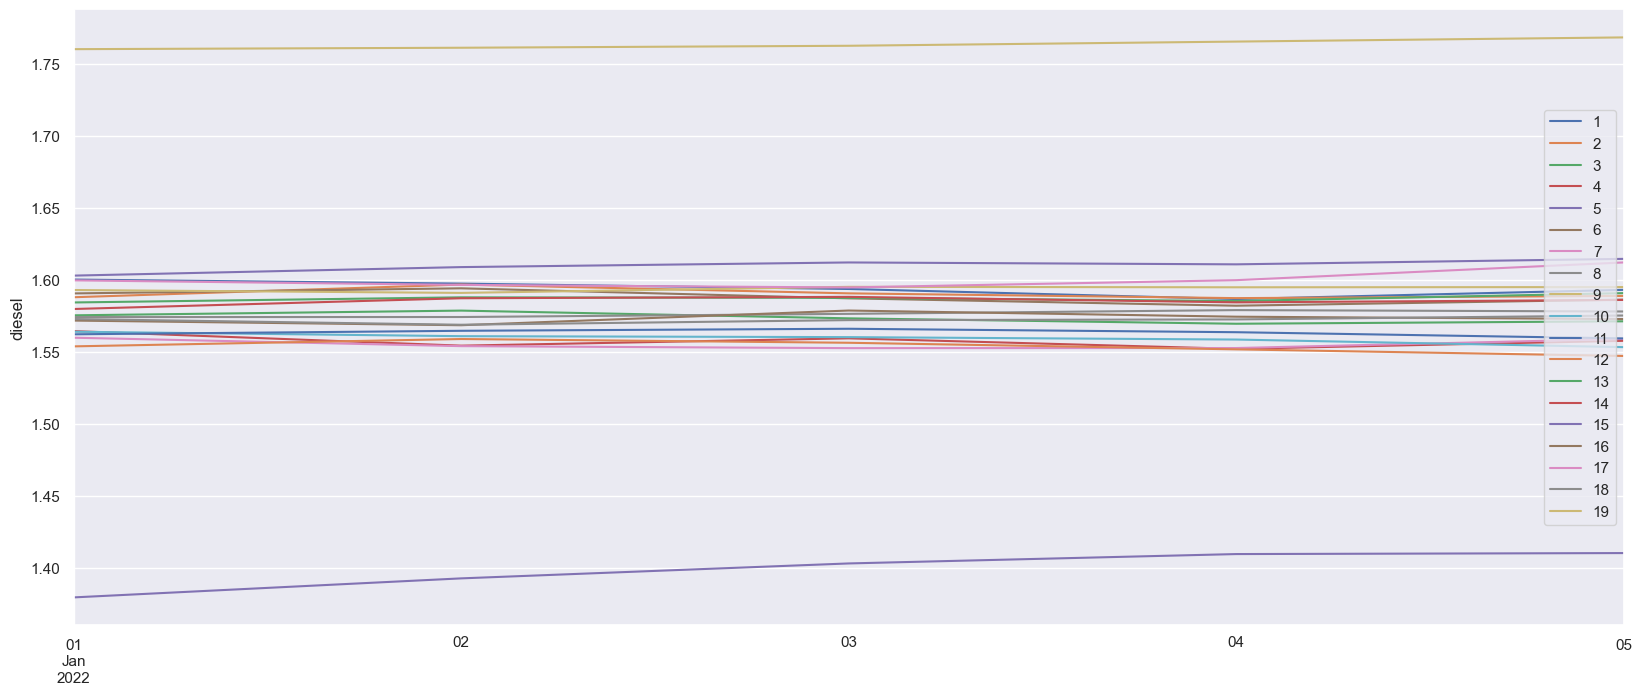

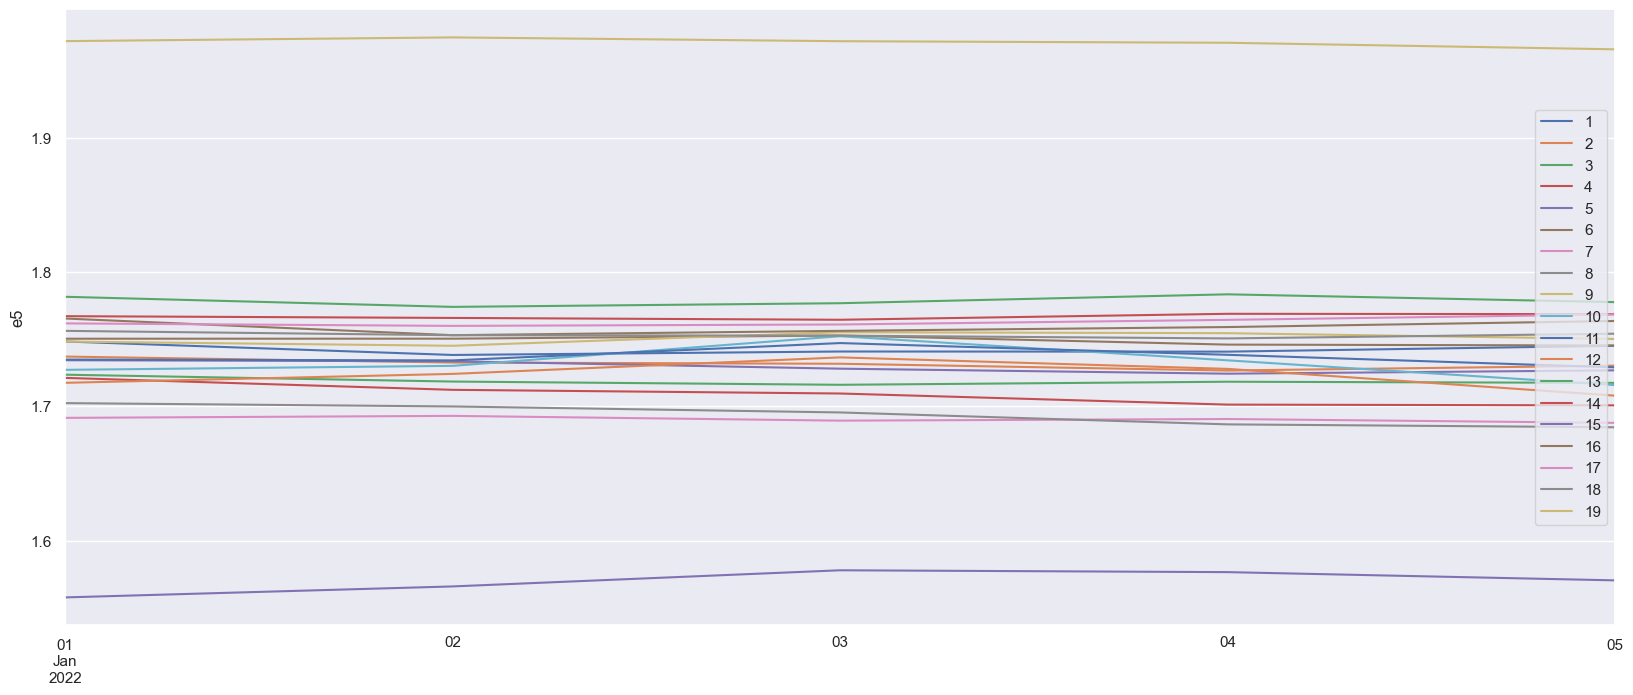

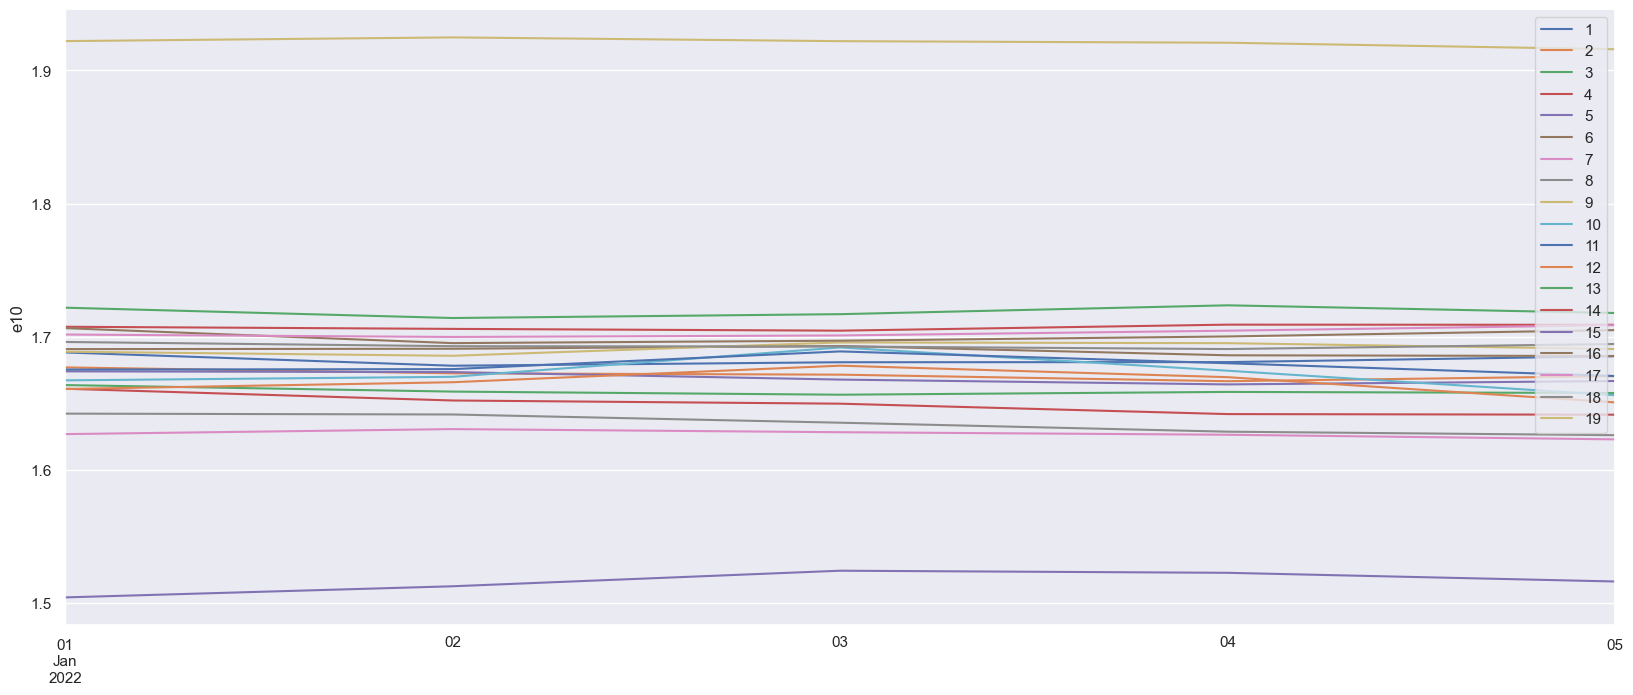

In [71]:
ax = predictionsdiesel.plot()
ax.set_ylabel("diesel")
plt.savefig('predictiondiesel.svg')
plt.show()
ax = predictionse5.plot()
ax.set_ylabel("e5")
plt.savefig('predictione5.svg')
plt.show()
ax = predictionse10.plot()
ax.set_ylabel("e10")
plt.savefig('predictione10.svg')
plt.show()


Building time features data set from date index 
only hour, day of the week, month,quarter are used and the year is ignored to capture trend at any date of the year

In [72]:

def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop(target, axis=1)
        return X, y

    return X

In [73]:
datin =pd.date_range(start='2022-01-01 00:00:00+00:00 ', end='2022-01-05 23:00:00+00:00', freq='h',tz='UTC')
df_pred =pd.DataFrame([])
df_pred['date'] =datin

Using StandaradScaler to transform to time features to scale 

In [74]:
scaler = StandardScaler()

Fitting on lightBGM model and predicting hourly value for next 5 days 

In [75]:
predictionldiesel=pd.DataFrame([])
predictionldiesel['date'] =datin
split_date = '2021-12-31'
for n in range(aggdf2['station_uuid'].nunique()):
  ggdf4=pd.DataFrame([])
  ggdf4 = ggdf4.append(aggdf2[aggdf2.station_uuid==n+1].set_index('date')['diesel'])
  ggdf4 = ggdf4.T
  ggdf4['date'] = ggdf4.index
  df_training = ggdf4
  X_train_df, y_train = create_time_features(df_training, target='diesel')
  X_pred_df = create_time_features(df_pred)
  scaler.fit(X_train_df)  # scaling on the training
  X_train = scaler.transform(X_train_df)
  X_pred = scaler.transform(X_pred_df)
  lightGBM = lgb.LGBMRegressor()
  lightGBM.fit(X_train, y_train)
  yhat = lightGBM.predict(X_pred)
  predictionldiesel[str(n+1)] = yhat.T

C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2826394966.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ggdf4 = ggdf4.append(aggdf2[aggdf2.station_uuid==n+1].set_index('date')['diesel'])
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2826394966.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ggdf4 = ggdf4.append(aggdf2[aggdf2.station_uuid==n+1].set_index('date')['diesel'])
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2826394966.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ggdf4 = ggdf4.append(aggdf2[aggdf2.station_uuid==n+1].set_index('date')['diesel'])
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\2826394966.py:6: FutureWarning: The frame.append method is deprecated and will be removed from 

In [76]:
predictionle5=pd.DataFrame([])
predictionle5['date'] =datin
split_date = '2021-12-31'
for n in range(aggdf2['station_uuid'].nunique()):
  ggdf4=pd.DataFrame([])
  ggdf4 = ggdf4.append(aggdf2[aggdf2.station_uuid==n+1].set_index('date')['e5'])
  ggdf4 = ggdf4.T
  ggdf4['date'] = ggdf4.index
  df_training = ggdf4
  X_train_df, y_train = create_time_features(df_training, target='e5')
  X_pred_df = create_time_features(df_pred)
  scaler.fit(X_train_df)  # scaling on the training
  X_train = scaler.transform(X_train_df)
  X_pred = scaler.transform(X_pred_df)
  lightGBM = lgb.LGBMRegressor()
  lightGBM.fit(X_train, y_train)
  yhat = lightGBM.predict(X_pred)
  predictionle5[str(n+1)] = yhat.T

C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\618841876.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ggdf4 = ggdf4.append(aggdf2[aggdf2.station_uuid==n+1].set_index('date')['e5'])
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\618841876.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ggdf4 = ggdf4.append(aggdf2[aggdf2.station_uuid==n+1].set_index('date')['e5'])
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\618841876.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ggdf4 = ggdf4.append(aggdf2[aggdf2.station_uuid==n+1].set_index('date')['e5'])
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\618841876.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

In [77]:
predictionle10=pd.DataFrame([])
predictionle10['date'] =datin
split_date = '2021-12-31'
for n in range(aggdf2['station_uuid'].nunique()):
  ggdf4=pd.DataFrame([])
  ggdf4 = ggdf4.append(aggdf2[aggdf2.station_uuid==n+1].set_index('date')['e10'])
  ggdf4 = ggdf4.T
  ggdf4['date'] = ggdf4.index
  df_training = ggdf4
  X_train_df, y_train = create_time_features(df_training, target='e10')
  X_pred_df = create_time_features(df_pred)
  scaler.fit(X_train_df)  # scaling on the training
  X_train = scaler.transform(X_train_df)
  X_pred = scaler.transform(X_pred_df)
  lightGBM = lgb.LGBMRegressor()
  lightGBM.fit(X_train, y_train)
  yhat = lightGBM.predict(X_pred)
  predictionle10[str(n+1)] = yhat.T

C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\3009465525.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ggdf4 = ggdf4.append(aggdf2[aggdf2.station_uuid==n+1].set_index('date')['e10'])
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\3009465525.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ggdf4 = ggdf4.append(aggdf2[aggdf2.station_uuid==n+1].set_index('date')['e10'])
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\3009465525.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ggdf4 = ggdf4.append(aggdf2[aggdf2.station_uuid==n+1].set_index('date')['e10'])
C:\Users\gowth\AppData\Local\Temp\ipykernel_10016\3009465525.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

In [78]:
predictionle5

date         1         2         3         4  \
0   2022-01-01 00:00:00+00:00  1.422171  1.453778  1.421476  1.391144   
1   2022-01-01 01:00:00+00:00  1.427088  1.460440  1.428781  1.396926   
2   2022-01-01 02:00:00+00:00  1.431166  1.469384  1.438655  1.401902   
3   2022-01-01 03:00:00+00:00  1.435999  1.477228  1.447539  1.405833   
4   2022-01-01 04:00:00+00:00  1.442020  1.485055  1.455033  1.412699   
..                        ...       ...       ...       ...       ...   
115 2022-01-05 19:00:00+00:00  1.402446  1.402160  1.401224  1.378184   
116 2022-01-05 20:00:00+00:00  1.401010  1.403082  1.395072  1.373235   
117 2022-01-05 21:00:00+00:00  1.405289  1.416998  1.400469  1.379001   
118 2022-01-05 22:00:00+00:00  1.414842  1.432351  1.406205  1.386601   
119 2022-01-05 23:00:00+00:00  1.422625  1.438541  1.414038  1.392048   

            5         6         7         8         9        10        11  \
0    1.450160  1.446546  1.374924  1.387086  1.472811  1.481449  1.458686   
1    1.451462  1.456935  1.373426  1.383503  1.471002  1.484004  1.463438   
2    1.454149  1.468277  1.372841  1.378349  1.469422  1.484708  1.468248   
3    1.456131  1.481524  1.371511  1.373135  1.468396  1.486575  1.472977   
4    1.456635  1.493337  1.370938  1.368416  1.466170  1.488473  1.480058   
..        ...       ...       ...       ...       ...       ...       ...   
115  1.409038  1.376472  1.359595  1.367955  1.471641  1.457257  1.455187   
116  1.385366  1.361075  1.351654  1.358162  1.451232  1.451299  1.425997   
117  1.414921  1.382561  1.354806  1.357778  1.457823  1.447876  1.426550   
118  1.447085  1.412810  1.364564  1.362355  1.461268  1.471456  1.428901   
119  1.449214  1.424813  1.370428  1.367690  1.463380  1.473991  1.431954   

           12        13        14        15        16        17        18  \
0    1.445052  1.414140  1.448621  1.420042  1.396711  1.456352  1.424742   
1    1.447490  1.418589  1.458986  1.435145  1.401358  1.457642  1.438978   
2    1.450437  1.428631  1.468776  1.450334  1.406205  1.457849  1.454989   
3    1.453604  1.437768  1.480047  1.465984  1.411792  1.457699  1.471829   
4    1.461459  1.448581  1.489335  1.480360  1.418395  1.457940  1.483656   
..        ...       ...       ...       ...       ...       ...       ...   
115  1.444760  1.401268  1.385681  1.371773  1.372232  1.419189  1.400374   
116  1.420883  1.379887  1.362772  1.362585  1.357208  1.416402  1.370002   
117  1.414439  1.385666  1.362709  1.358855  1.356978  1.442997  1.373598   
118  1.417518  1.390699  1.420276  1.364142  1.365921  1.469128  1.390932   
119  1.426728  1.402423  1.429166  1.383126  1.376570  1.471043  1.404382   

           19  
0    1.739000  
1    1.739000  
2    1.739000  
3    1.738913  
4    1.738880  
..        ...  
115  1.739004  
116  1.739077  
117  1.739169  
118  1.739022  
119  1.739022  

[120 rows x 20 columns]

In [79]:
ensemblediesel = pd.DataFrame([])
ensemblee5  = pd.DataFrame([])
ensemblee10 = pd.DataFrame([])

In [80]:
ensemblediesel['date'] =datin
ensemblee5['date'] =datin
ensemblee10['date'] =datin



> Ensembling both values  on below method I chose to add the values of hourly predictions shifted to zero mean to Autoreg mean ther by adding volatility  over the mean value to make the prediction more accurate.



In [81]:
for n in range(aggdf2['station_uuid'].nunique()):
  for i in range(5):
    rowIndex = predictionldiesel.index[i*24:(i+1)*24]
    ensemblediesel.loc[rowIndex,str(n+1)] = predictionsdiesel[str(n+1)].values[i] +predictionldiesel.loc[rowIndex,str(n+1)] - predictionldiesel.loc[rowIndex,str(n+1)].mean()
    ensemblee5.loc[rowIndex,str(n+1)] = predictionse5[str(n+1)].values[i] +predictionle5.loc[rowIndex,str(n+1)] - predictionle5.loc[rowIndex,str(n+1)].mean()
    ensemblee10.loc[rowIndex,str(n+1)] = predictionse10[str(n+1)].values[i] +predictionle10.loc[rowIndex,str(n+1)] - predictionle10.loc[rowIndex,str(n+1)].mean()

In [82]:
# for n in range(aggdf2['station_uuid'].nunique()):
#   predictionle10['station_uuid'+str(n+1)] += predictionse10['station_uuid'+str(n+1)].values[0] -predictionle10['station_uuid'+str(n+1)].values[0]

In [83]:
predictionldiesel =predictionldiesel.set_index('date')
predictionle5 =predictionle5.set_index('date')
predictionle10 =predictionle10.set_index('date')

In [84]:
ensemblediesel

date         1         2         3         4  \
0   2022-01-01 00:00:00+00:00  1.599631  1.601052  1.570171  1.566946   
1   2022-01-01 01:00:00+00:00  1.604315  1.608018  1.576615  1.570992   
2   2022-01-01 02:00:00+00:00  1.606861  1.613480  1.581938  1.574893   
3   2022-01-01 03:00:00+00:00  1.611827  1.619712  1.590346  1.579984   
4   2022-01-01 04:00:00+00:00  1.615960  1.624919  1.595756  1.580642   
..                        ...       ...       ...       ...       ...   
115 2022-01-05 19:00:00+00:00  1.570049  1.557559  1.544903  1.534868   
116 2022-01-05 20:00:00+00:00  1.566809  1.558104  1.536270  1.529260   
117 2022-01-05 21:00:00+00:00  1.571137  1.571555  1.539157  1.534228   
118 2022-01-05 22:00:00+00:00  1.577717  1.587143  1.543738  1.540367   
119 2022-01-05 23:00:00+00:00  1.583946  1.592491  1.550187  1.543958   

            5         6         7         8         9        10        11  \
0    1.619151  1.617398  1.558959  1.578156  1.597199  1.574426  1.555510   
1    1.619151  1.626101  1.557788  1.574837  1.594048  1.576008  1.562125   
2    1.619733  1.635207  1.556343  1.571846  1.593993  1.576065  1.568449   
3    1.619975  1.643529  1.554607  1.567720  1.593953  1.576568  1.574428   
4    1.619975  1.654292  1.553727  1.565278  1.593335  1.578003  1.582259   
..        ...       ...       ...       ...       ...       ...       ...   
115  1.601807  1.543155  1.544036  1.575893  1.595831  1.527218  1.549884   
116  1.579197  1.533465  1.533387  1.567381  1.569101  1.518329  1.523092   
117  1.606585  1.554551  1.538257  1.567229  1.572893  1.520940  1.521663   
118  1.637333  1.583035  1.547431  1.572424  1.577321  1.559032  1.523945   
119  1.637333  1.595262  1.554763  1.577138  1.579355  1.561845  1.529800   

           12        13        14        15        16        17        18  \
0    1.556013  1.590341  1.597553  1.383732  1.568764  1.633399  1.566650   
1    1.559981  1.592240  1.600166  1.389813  1.575654  1.633588  1.580682   
2    1.563230  1.594657  1.602711  1.397440  1.582662  1.633840  1.594774   
3    1.566091  1.598682  1.604388  1.402909  1.589971  1.633779  1.609579   
4    1.569782  1.599058  1.606715  1.409955  1.597396  1.632950  1.622727   
..        ...       ...       ...       ...       ...       ...       ...   
115  1.535467  1.578788  1.556194  1.379487  1.549822  1.595539  1.556146   
116  1.512376  1.554241  1.533676  1.368778  1.529784  1.592493  1.525461   
117  1.515348  1.560481  1.537781  1.368636  1.528881  1.623429  1.531386   
118  1.522231  1.565977  1.589821  1.370256  1.537269  1.652986  1.546277   
119  1.535122  1.570496  1.592878  1.380811  1.545952  1.654021  1.559396   

           19  
0    1.760172  
1    1.760187  
2    1.760184  
3    1.760171  
4    1.760178  
..        ...  
115  1.768392  
116  1.768252  
117  1.768252  
118  1.768252  
119  1.768252  

[120 rows x 20 columns]

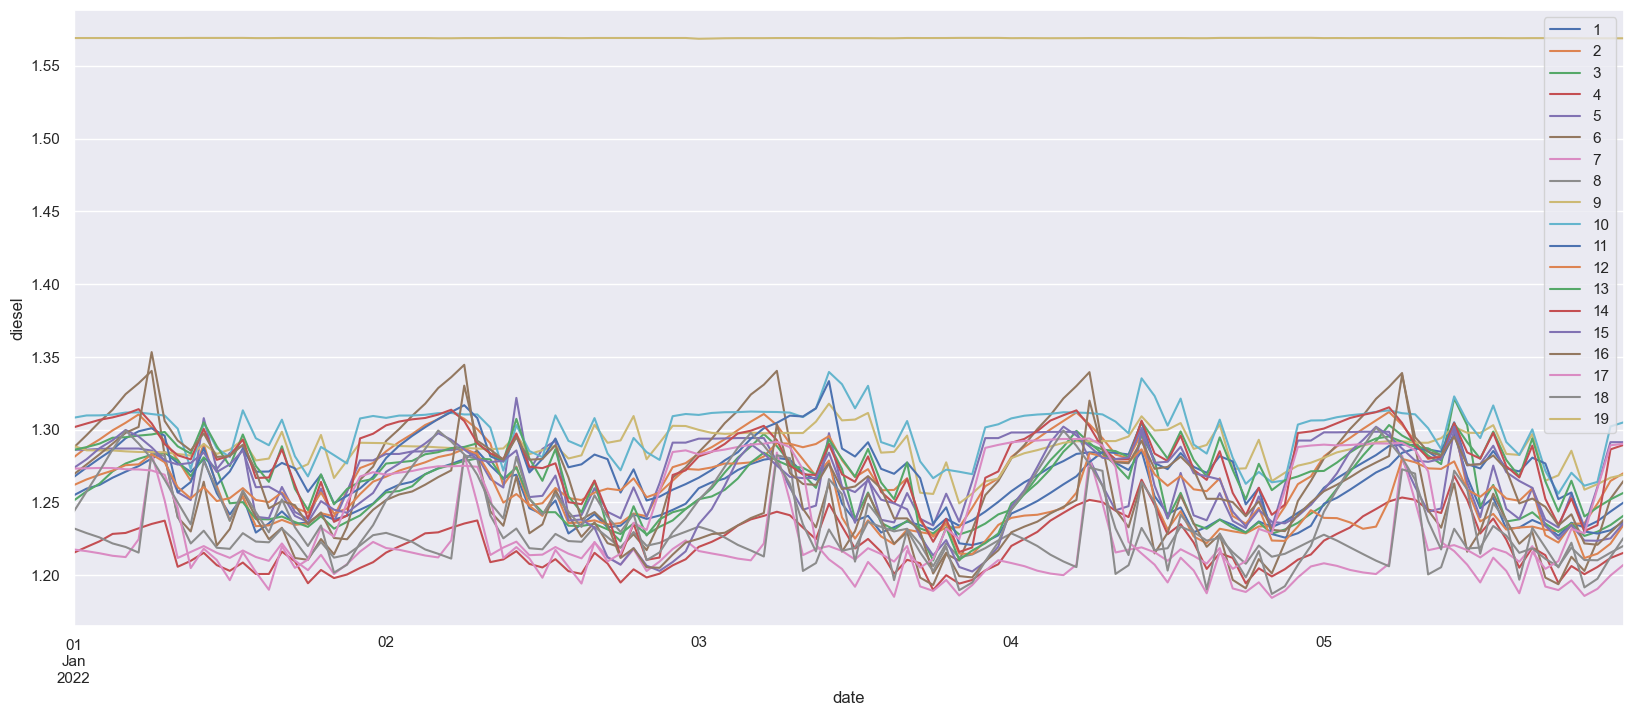

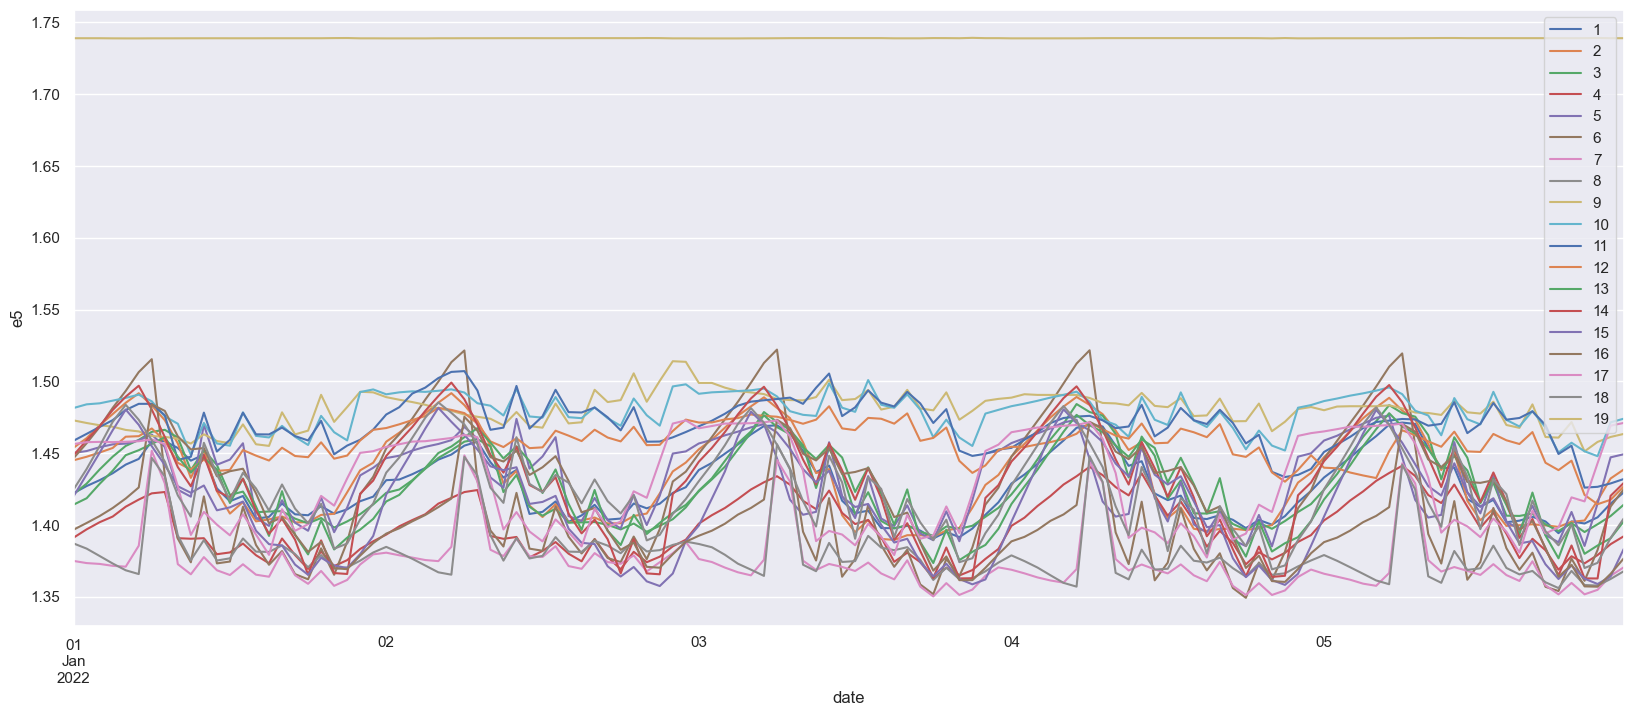

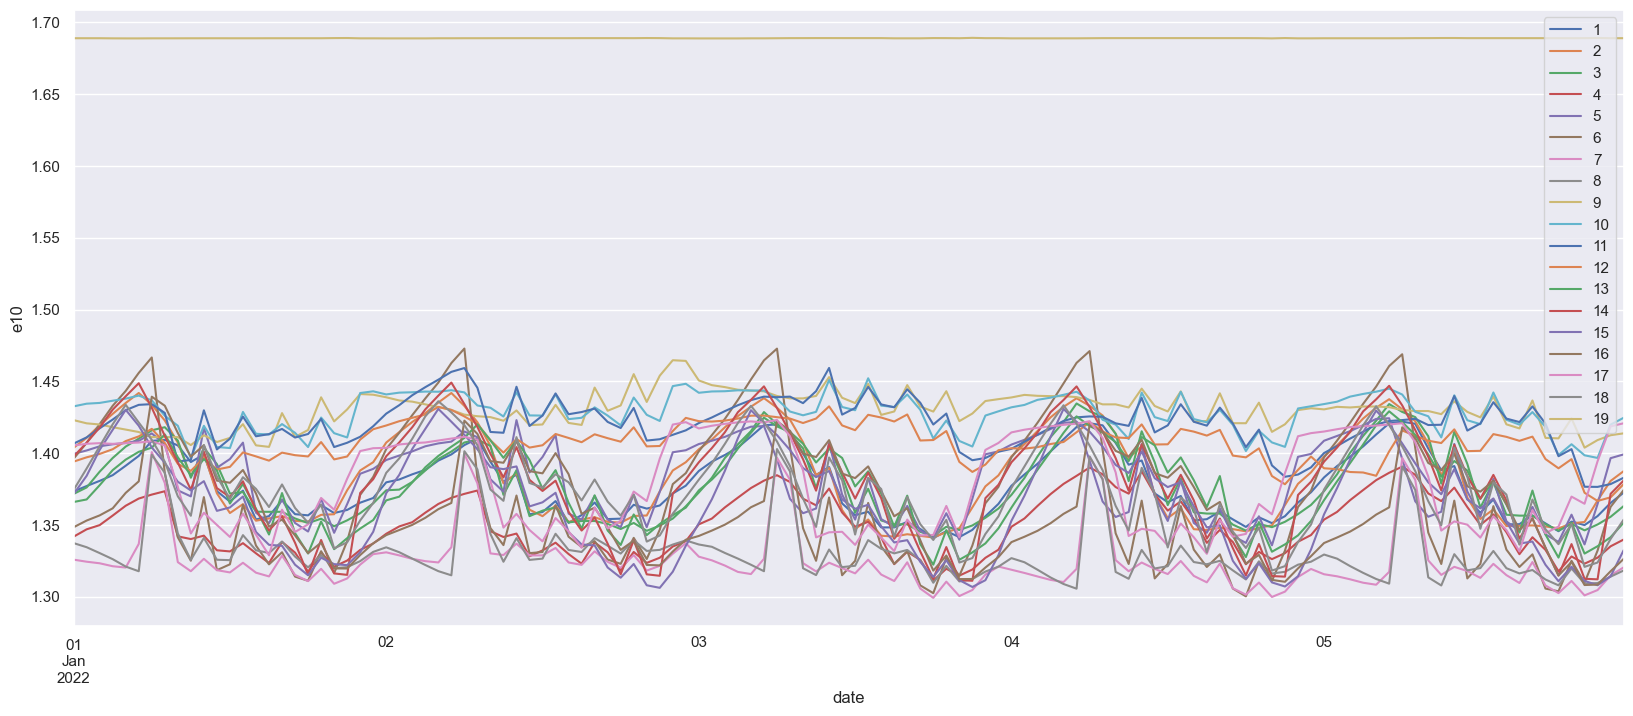

In [85]:
ax = predictionldiesel.plot()
ax.set_ylabel("diesel")
plt.savefig('predictionldiesel.svg')
plt.show()
ax =predictionle5.plot()
ax.set_ylabel("e5")
plt.savefig('predictionle5.svg')
plt.show()
ax = predictionle10.plot()
ax.set_ylabel("e10")
plt.savefig('predictionle10.svg')
plt.show()

In [86]:
ensemblediesel =ensemblediesel.set_index('date')
ensemblee5 =ensemblee5.set_index('date')
ensemblee10 =ensemblee10.set_index('date')

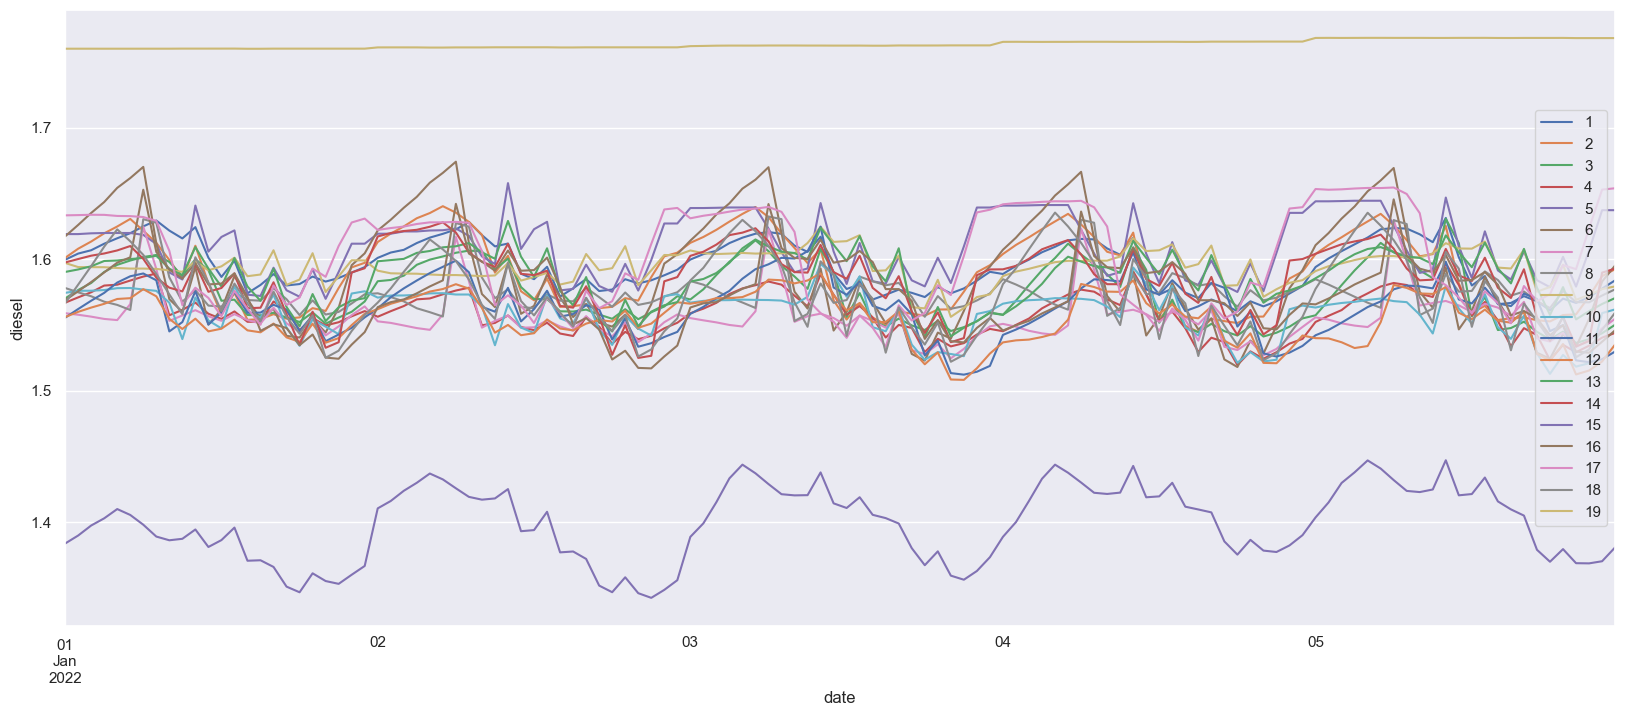

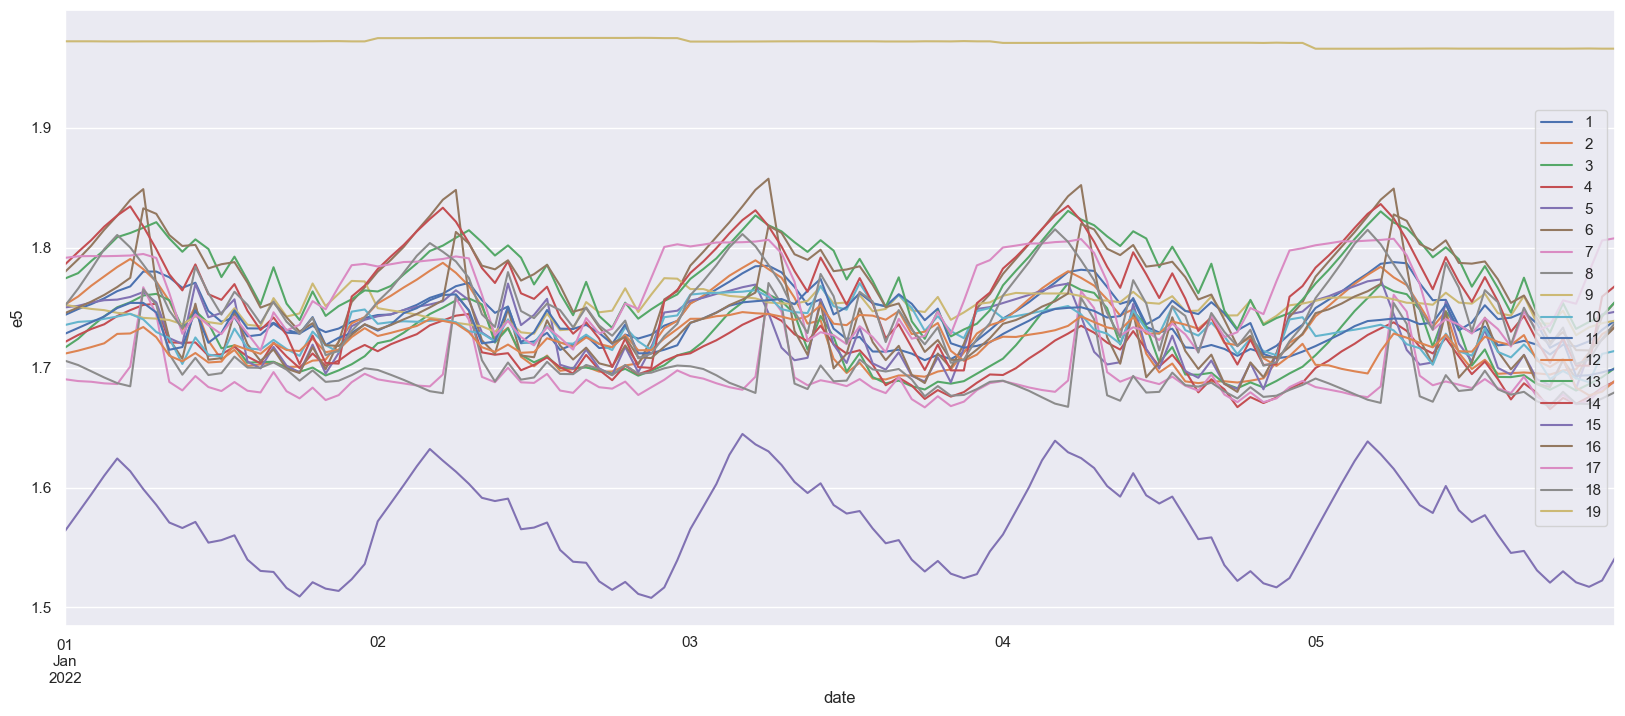

In [87]:
ax = ensemblediesel.plot()
ax.set_ylabel("diesel")
plt.savefig('ensemblediesel.svg')
plt.show() 
ax =ensemblee5.plot()
ax.set_ylabel("e5")
plt.savefig('ensemblee5.svg')
plt.show()
ax = ensemblee10.plot()
ax.set_ylabel("e10")
plt.savefig('ensemblee10.svg')
plt.show()

Reshaping the predictions values to required format 

In [88]:
ensemblediesel_stack = ensemblediesel.stack().reset_index()
ensemblee5_stack = ensemblee5.stack().reset_index()
ensemblee10_stack = ensemblee10.stack().reset_index()

In [89]:
ensemblediesel_stack = ensemblediesel_stack.groupby([ensemblediesel_stack['level_1'],ensemblediesel_stack['date']]).mean().reset_index()
ensemblee5_stack = ensemblee5_stack.groupby([ensemblee5_stack['level_1'],ensemblee5_stack['date']]).mean().reset_index()
ensemblee10_stack = ensemblee10_stack.groupby([ensemblee10_stack['level_1'],ensemblee10_stack['date']]).mean().reset_index()

In [90]:
ensembleassembled = pd.DataFrame([])

In [91]:
ensembleassembled['date'] = ensemblediesel_stack['date']
ensembleassembled['diesel'] = ensemblediesel_stack[0]
ensembleassembled['e5'] = ensemblee5_stack[0]
ensembleassembled['e10'] = ensemblee10_stack[0]

In [92]:
ensembleassembled.to_csv('ensemblefinal.csv')

Task 3 Clustering 

Concatinating the columns for each station 

In [93]:
ggdf4=pd.DataFrame([])
for n in range(aggdf2['station_uuid'].nunique()):
  
  ggdf4['stationid'+str(n+1)] = aggdf2[aggdf2.station_uuid==n+1].set_index('date')['diesel']+aggdf2[aggdf2.station_uuid==n+1].set_index('date')['e5'] + aggdf2[aggdf2.station_uuid==n+1].set_index('date')['e10']


*Using* PCA dimensionality reduction technique to reduces dimensions to 2 components.

In [94]:
pca_2 = PCA(n_components=1)
pca_2_result = pca_2.fit_transform(ggdf4)

In [95]:
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))

print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=ggdf4.columns, index=['PC_1']).T
dataset_pca

Explained variation per principal component: [0.93303341]
Cumulative variance explained by 2 principal components: 93.30%


PC_1
stationid1   0.236232
stationid2   0.228053
stationid3   0.226160
stationid4   0.227502
stationid5   0.232638
stationid6   0.247386
stationid7   0.245558
stationid8   0.247896
stationid9   0.215558
stationid10  0.197364
stationid11  0.219238
stationid12  0.211351
stationid13  0.251792
stationid14  0.243355
stationid15  0.240714
stationid16  0.241622
stationid17  0.243129
stationid18  0.240579
stationid19  0.134615

Cumulative variance explained by 2 principal components is above 94 percent which is sufficient enough for describing the data

Visualisng the PC components using Scatter plot.

In [96]:
dataset_pca['PCT'] = ggdf4.pct_change().mean()

In [97]:
dataset_pca


PC_1       PCT
stationid1   0.236232  0.000161
stationid2   0.228053  0.000150
stationid3   0.226160  0.000168
stationid4   0.227502  0.000118
stationid5   0.232638  0.000216
stationid6   0.247386  0.000282
stationid7   0.245558  0.000161
stationid8   0.247896  0.000149
stationid9   0.215558  0.000137
stationid10  0.197364  0.000141
stationid11  0.219238  0.000166
stationid12  0.211351  0.000141
stationid13  0.251792  0.000157
stationid14  0.243355  0.000192
stationid15  0.240714  0.000153
stationid16  0.241622  0.000133
stationid17  0.243129  0.000199
stationid18  0.240579  0.000174
stationid19  0.134615  0.000015

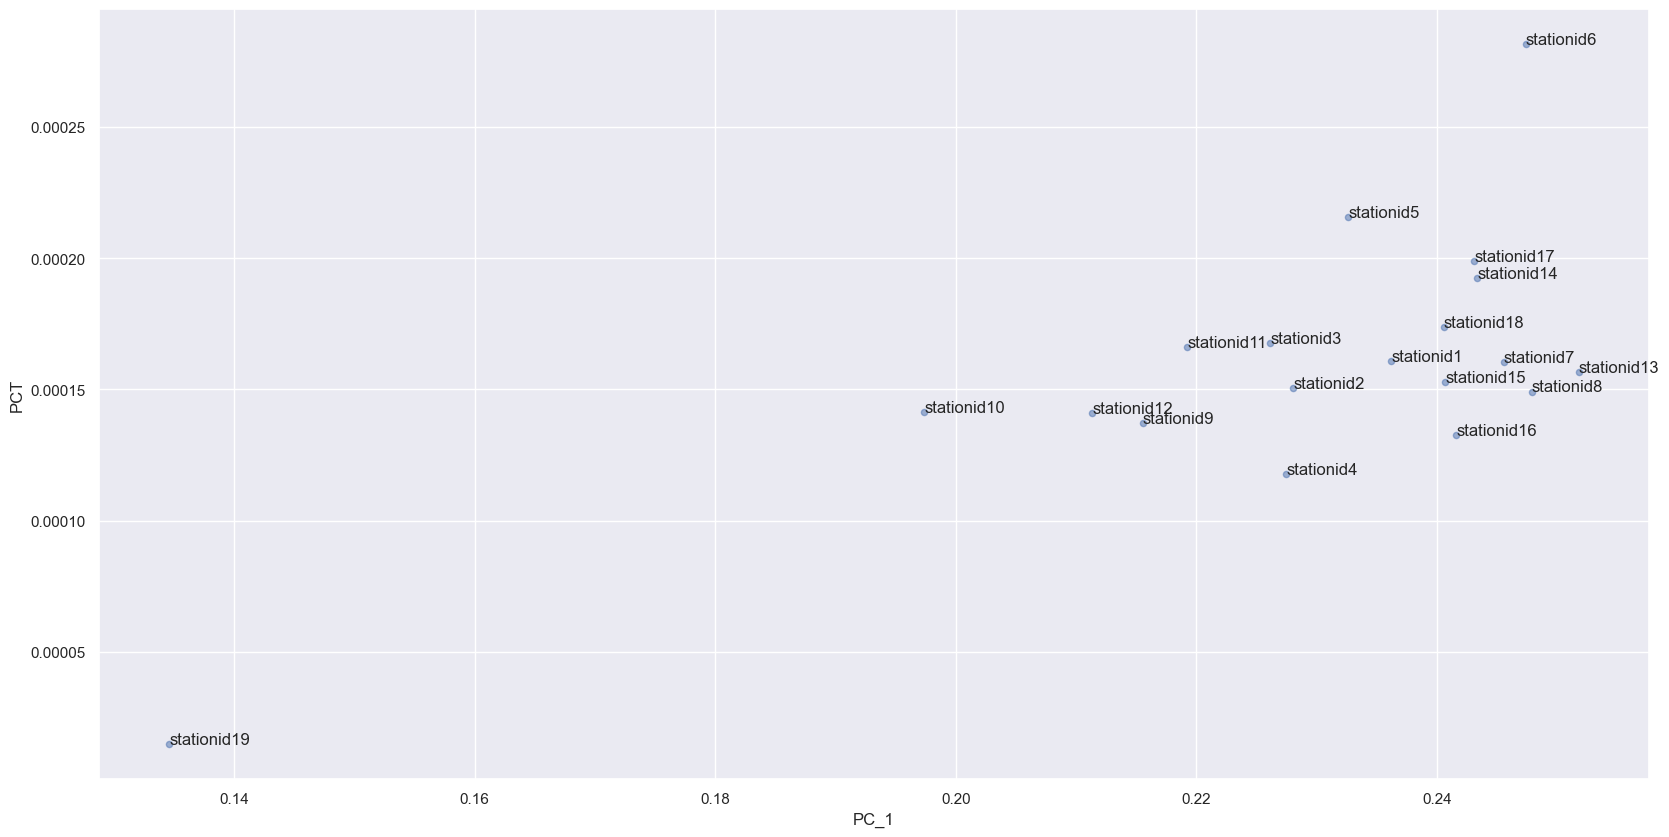

In [98]:
dataset_pca.plot.scatter(x='PC_1', y='PCT', alpha=0.5,figsize=(20, 10))

for idx, row in dataset_pca.iterrows(): 
    plt.text(row['PC_1'], row['PCT'], idx)
plt.show()

Using ParameterGrid feature and computing silhouette score to choose a better k value for clusters 




In [99]:
dataset_pca.values

array([[2.36232407e-01, 1.60820945e-04],
       [2.28052799e-01, 1.50490699e-04],
       [2.26160170e-01, 1.67677809e-04],
       [2.27501642e-01, 1.17695579e-04],
       [2.32638245e-01, 2.15635773e-04],
       [2.47386495e-01, 2.81585671e-04],
       [2.45558233e-01, 1.60511863e-04],
       [2.47895967e-01, 1.49178838e-04],
       [2.15558372e-01, 1.37265652e-04],
       [1.97364399e-01, 1.41416327e-04],
       [2.19237861e-01, 1.66124851e-04],
       [2.11350766e-01, 1.41171931e-04],
       [2.51791692e-01, 1.56690434e-04],
       [2.43355274e-01, 1.92349759e-04],
       [2.40713879e-01, 1.52772179e-04],
       [2.41622275e-01, 1.32733034e-04],
       [2.43129156e-01, 1.98864265e-04],
       [2.40578523e-01, 1.73900592e-04],
       [1.34615030e-01, 1.48585720e-05]])

d:\PP\envs\augmixenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\PP\envs\augmixenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\PP\envs\augmixenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\PP\envs\augmixenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_

Parameter: {'n_clusters': 2} Score 0.7747228581644553
Parameter: {'n_clusters': 3} Score 0.5818061529983165
Parameter: {'n_clusters': 4} Score 0.549265754222087
Parameter: {'n_clusters': 5} Score 0.5547929703478689


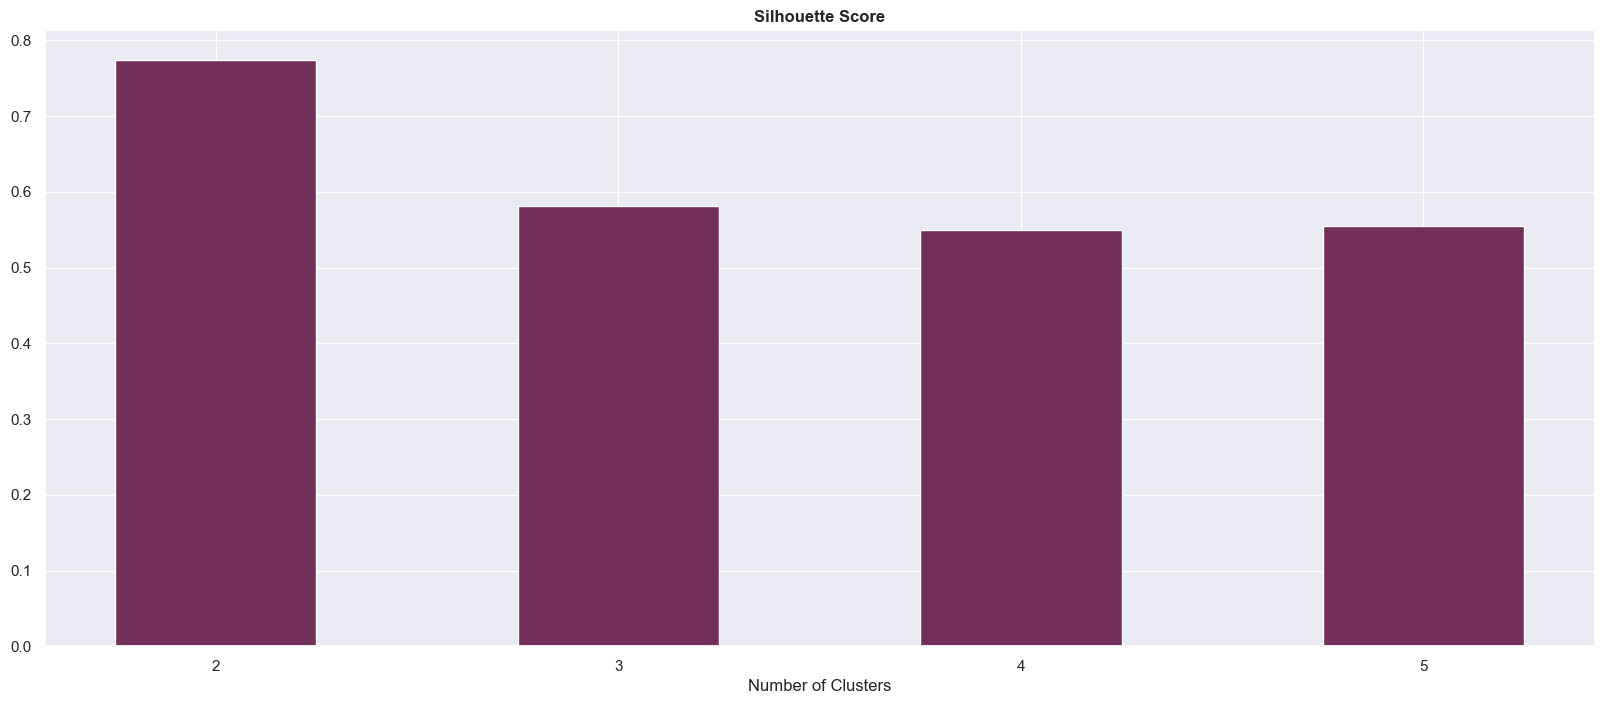

In [100]:
parameters = [2,3, 4, 5]
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(dataset_pca.values)          # fit model on  dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(dataset_pca, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score

# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.savefig('Silhouette.svg')
plt.show()



Based on the high Silhouette Score a k value of 2 is chosen
---



In [101]:
Model = KMeans(n_clusters= 3)
Model.fit(dataset_pca.values)
label = Model.fit_predict(dataset_pca.values)
 
print(label)

[2 0 0 0 2 2 2 2 0 0 0 0 2 2 2 2 2 2 1]


d:\PP\envs\augmixenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\PP\envs\augmixenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\PP\envs\augmixenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\PP\envs\augmixenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_

In [102]:
dataset_pca['label'] = label

In [103]:
dataset_pca

PC_1       PCT  label
stationid1   0.236232  0.000161      2
stationid2   0.228053  0.000150      0
stationid3   0.226160  0.000168      0
stationid4   0.227502  0.000118      0
stationid5   0.232638  0.000216      2
stationid6   0.247386  0.000282      2
stationid7   0.245558  0.000161      2
stationid8   0.247896  0.000149      2
stationid9   0.215558  0.000137      0
stationid10  0.197364  0.000141      0
stationid11  0.219238  0.000166      0
stationid12  0.211351  0.000141      0
stationid13  0.251792  0.000157      2
stationid14  0.243355  0.000192      2
stationid15  0.240714  0.000153      2
stationid16  0.241622  0.000133      2
stationid17  0.243129  0.000199      2
stationid18  0.240579  0.000174      2
stationid19  0.134615  0.000015      1

In [104]:
dataset_pca.to_csv('clustered_data.csv')

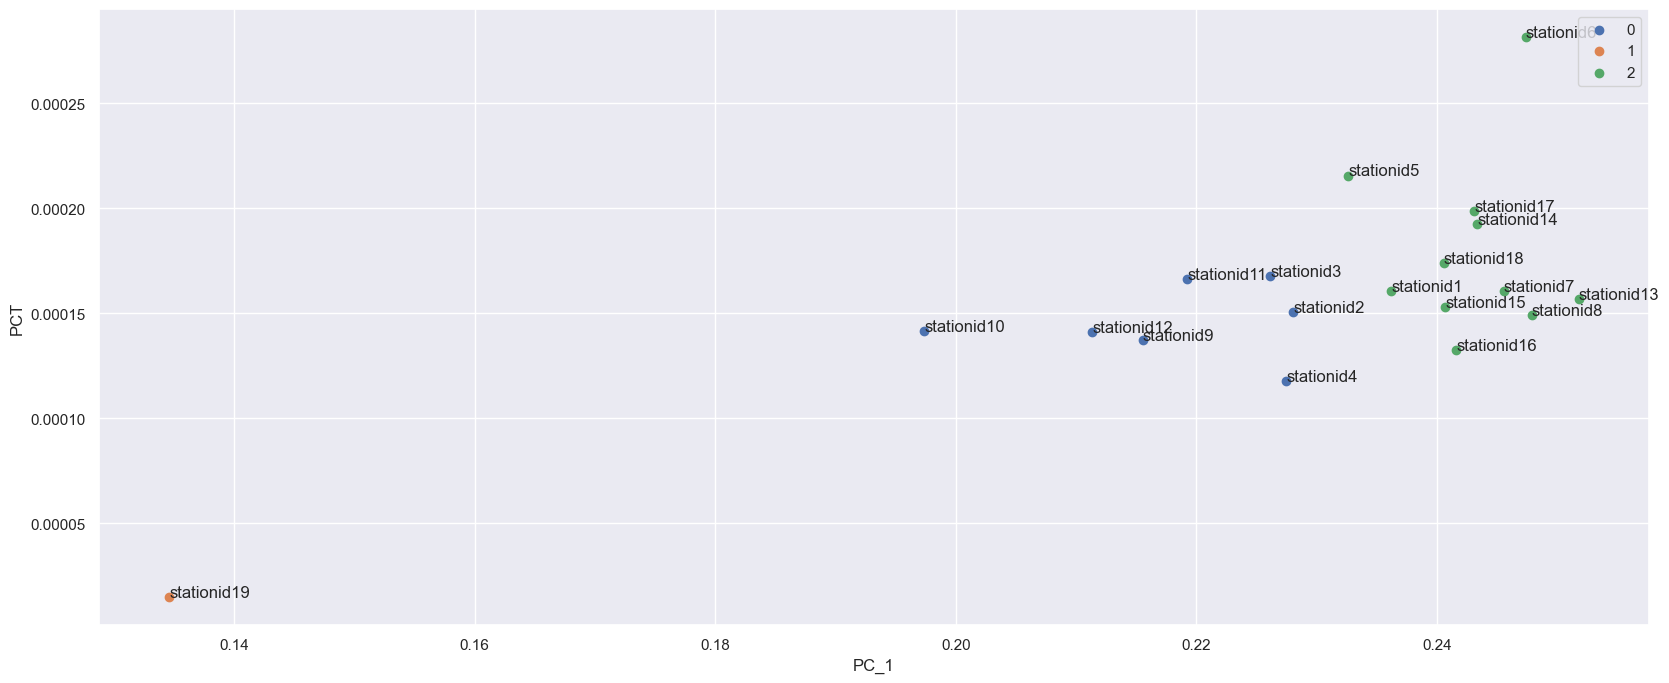

In [105]:
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter( dataset_pca[dataset_pca.label== i].PC_1 , y = dataset_pca[dataset_pca.label== i].PCT,label = i)
for idx, row in dataset_pca.iterrows(): 
    plt.text(row['PC_1'],row['PCT'] , idx)
plt.legend()
plt.xlabel('PC_1')
plt.ylabel('PCT')
plt.savefig('cluster.svg')
plt.show()
